# **Import**

In [161]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [162]:
df = pd.read_csv("dl_data.csv")

In [163]:
df.head()

,sentence_id,word,tag
0,1,My,O
1,1,face,B-BODY_PART
2,1,gets,O
3,1,too,O
4,1,oily,B-SKIN_TYPE


# **Preprocessing**

In [164]:
df.isnull().sum()

sentence_id    0
word           0
tag            0
dtype: int64

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3582 entries, 0 to 3581
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentence_id  3582 non-null   int64 
 1   word         3582 non-null   object
 2   tag          3582 non-null   object
dtypes: int64(1), object(2)
memory usage: 84.1+ KB


In [166]:
df.columns = ['sentence_id', 'word', 'tag']

In [167]:
df["word"] = df["word"].str.strip()
df["tag"] = df["tag"].str.strip()

In [168]:
df["tag"].nunique()

15

In [169]:
sentence_lengths = df.groupby("sentence_id")["word"].count()

min_len = sentence_lengths.min()
min_id = sentence_lengths.idxmin()
max_len = sentence_lengths.max()
max_id = sentence_lengths.idxmax()

print(f"Shortest sentence_id: {min_id}, Length: {min_len}")
print(f"Longest sentence_id: {max_id}, Length: {max_len}")

shortest_sentence = df[df["sentence_id"] == min_id]["word"].tolist()
print(" ".join(shortest_sentence))
longest_sentence = df[df["sentence_id"] == max_id]["word"].tolist()
print(" ".join(longest_sentence))

Shortest sentence_id: 379, Length: 4
Longest sentence_id: 159, Length: 18
My nose has blackheads
I feel my skin has become sensitive to sunscreen as it starts to sting whenever I apply it


In [170]:
sentences = df.groupby("sentence_id")["word"].apply(list).values
labels = df.groupby("sentence_id")["tag"].apply(list).values

print(f"Total sentences: {len(sentences)}")
print(f"Total tags: {len(labels)}")

Total sentences: 402
Total tags: 402


In [171]:
words = list(set(df["word"].values))
tags = list(set(df["tag"].values))

In [172]:
len(tags)

15

In [173]:
words.append("PAD")
words.append("UNK")

In [174]:
len(words)

401

In [175]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for t, i in tag2idx.items()}

print("Vocabulary size:", len(word2idx))
print("Number of tags:", len(tag2idx))

Vocabulary size: 401
Number of tags: 15


# **Splitting**

In [176]:
X = [[word2idx.get(w, word2idx["UNK"]) for w in s] for s in sentences]
y = [[tag2idx[t] for t in ts] for ts in labels]

In [177]:
MAX_LEN = 25

X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["O"])

In [178]:
y = [to_categorical(i, num_classes=len(tag2idx)) for i in y]

In [179]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train sentences:", X_train.shape)
print("Validation sentences:", X_val.shape)

Train sentences: (321, 25)
Validation sentences: (81, 25)


# **Embeddings**

In [180]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [181]:
# Step 1: Load GloVe
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector
print(f"Loaded {len(embeddings_index)} word vectors.")

# Step 2: Create Embedding Matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word2idx), embedding_dim))

for word, i in word2idx.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

# Step 3: Create Embedding Layer
embedding_layer = nn.Embedding.from_pretrained(
    torch.tensor(embedding_matrix, dtype=torch.float32),
    freeze=False  # allows fine-tuning during training
)

Loaded 400000 word vectors.


In [182]:
embedding_dim = 100  # since we're using glove.6B.100d.txt
embedding_matrix = np.zeros((len(word2idx), embedding_dim))

# Fill the embedding matrix
for word, i in word2idx.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector
    else:
        # for OOV words
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

# Create embedding layer
embedding_layer = nn.Embedding.from_pretrained(
    torch.tensor(embedding_matrix, dtype=torch.float32),
    freeze=False  # fine-tune during training
)

# **BiLSTM**

In [183]:
import sys
print(sys.executable)
print(sys.path)

c:\Users\shehr\AppData\Local\Programs\Python\Python313\python.exe
['c:\\Users\\shehr\\AppData\\Local\\Programs\\Python\\Python313\\python313.zip', 'c:\\Users\\shehr\\AppData\\Local\\Programs\\Python\\Python313\\DLLs', 'c:\\Users\\shehr\\AppData\\Local\\Programs\\Python\\Python313\\Lib', 'c:\\Users\\shehr\\AppData\\Local\\Programs\\Python\\Python313', '', 'C:\\Users\\shehr\\AppData\\Roaming\\Python\\Python313\\site-packages', 'c:\\Users\\shehr\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages']


In [184]:
import subprocess
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'pytorch-crf'])

0

In [185]:
import subprocess
import sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'torchcrf'])

0

In [186]:
import torch.nn as nn
from torchcrf import CRF

class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim, embeddings=None):
        super().__init__()
        if embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embeddings), freeze=False, padding_idx=0)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, sentences, tags=None):
        embeds = self.embedding(sentences)
        lstm_out, _ = self.lstm(embeds)
        emissions = self.hidden2tag(lstm_out)
        
        if tags is not None:
            # Training: Return negative log likelihood
            # Create mask for padding (assuming 0 is padding index)
            mask = sentences != 0
            loss = -self.crf(emissions, tags, mask=mask, reduction='mean')
            return loss
        else:
            # Inference: Return best path
            mask = sentences != 0
            return self.crf.decode(emissions, mask=mask)


In [187]:
train_X_tensor = torch.LongTensor(X_train)   # [num_samples, max_len]
train_y_tensor = torch.LongTensor(y_train)   # [num_samples, max_len]
val_X_tensor = torch.LongTensor(X_val)
val_y_tensor = torch.LongTensor(y_val)

In [188]:
import torch.nn as nn
from torchcrf import CRF

class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim, embeddings=None):
        super().__init__()
        if embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embeddings), freeze=False, padding_idx=0)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, sentences, tags=None):
        embeds = self.embedding(sentences)
        lstm_out, _ = self.lstm(embeds)
        emissions = self.hidden2tag(lstm_out)
        
        if tags is not None:
            # Training: Return negative log likelihood
            # Create mask for padding (assuming 0 is padding index)
            mask = sentences != 0
            loss = -self.crf(emissions, tags, mask=mask, reduction='mean')
            return loss
        else:
            # Inference: Return best path
            mask = sentences != 0
            return self.crf.decode(emissions, mask=mask)


# **Training**

In [189]:
import torch.optim as optim

model = BiLSTM_NER(
    vocab_size=len(word2idx),
    tagset_size=len(tag2idx),
    embedding_dim=100,      # Your embedding dim
    hidden_dim=256,         # Your chosen hidden dim
    embeddings=embedding_matrix
)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss(ignore_index=0)     # No longer needed for CRF

batch_size = 32

for epoch in range(1, 51):
    model.train()
    total_loss = 0

    for i in range(0, len(train_X_tensor), batch_size):
        sentences = train_X_tensor[i:i+batch_size]
        labels = train_y_tensor[i:i+batch_size]

        if labels.ndim == 3:
          # From one-hot ([batch, seq_len, tagset_size]) to integer IDs ([batch, seq_len])
          labels = labels.argmax(-1)


        optimizer.zero_grad()
        # CRF returns loss directly when tags are provided
        loss = model(sentences, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Print shapes to debug, comment out if okay
        # print(f'batch {i//batch_size+1}: loss {loss.item()}')

    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 443.6889
Epoch 2, Loss: 171.9219
Epoch 3, Loss: 144.2739
Epoch 4, Loss: 132.5494
Epoch 5, Loss: 119.9497
Epoch 6, Loss: 107.0353
Epoch 7, Loss: 92.6837
Epoch 8, Loss: 78.8628
Epoch 9, Loss: 66.7988
Epoch 10, Loss: 56.9229
Epoch 11, Loss: 48.9681
Epoch 12, Loss: 42.3940
Epoch 13, Loss: 36.9160
Epoch 14, Loss: 32.3030
Epoch 15, Loss: 28.3876
Epoch 16, Loss: 25.0334
Epoch 17, Loss: 22.1642
Epoch 18, Loss: 19.7074
Epoch 19, Loss: 17.5965
Epoch 20, Loss: 15.7712
Epoch 21, Loss: 14.1824
Epoch 22, Loss: 12.7996
Epoch 23, Loss: 11.5969
Epoch 24, Loss: 10.5451
Epoch 25, Loss: 9.6165
Epoch 26, Loss: 8.7905
Epoch 27, Loss: 8.0539
Epoch 28, Loss: 7.3970
Epoch 29, Loss: 6.8113
Epoch 30, Loss: 6.2906
Epoch 31, Loss: 5.8348
Epoch 32, Loss: 5.4447
Epoch 33, Loss: 5.1283
Epoch 34, Loss: 4.9448
Epoch 35, Loss: 5.1258
Epoch 36, Loss: 5.7710
Epoch 37, Loss: 6.4887
Epoch 38, Loss: 5.5168
Epoch 39, Loss: 4.1830
Epoch 40, Loss: 3.7746
Epoch 41, Loss: 3.3518
Epoch 42, Loss: 3.1786
Epoch 43, Los

# **Evaluation**

In [190]:
model.eval()
with torch.no_grad():
    for i in range(0, len(val_X_tensor), batch_size):
        sentences = val_X_tensor[i:i+batch_size]
        # CRF decode returns list of lists of tag indices
        predictions = model(sentences)
        
        # Loop through predictions to map to string tags:
        for sent_pred in predictions:
            tags = [idx2tag[idx] for idx in sent_pred]
            print(tags)

['O', 'B-BODY_PART', 'O', 'O', 'O', 'B-SEVERITY', 'B-SYMPTOM', 'O', 'B-SEASON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'B-SKIN_TYPE', 'I-SKIN_TYPE', 'O', 'B-SYMPTOM', 'O', 'O', 'B-BODY_PART', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B-BODY_PART', 'O', 'B-SYMPTOM', 'O', 'B-SEASON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'B-SKIN_TYPE', 'I-SKIN_TYPE', 'O', 'O', 'B-SYMPTOM', 'O', 'O', 'B-BODY_PART', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B-SKIN_TYPE', 'O', 'B-SYMPTOM', 'O', 'B-SEASON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'B-SYMPTOM', 'I-SYMPTOM', 'O', 'O', 'O', 'B-BODY_PART', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'B-SEVERITY', 'B-SYMPTOM', 'O', 'O', 'B-BODY_PA

In [191]:
idx2word = {idx: word for word, idx in word2idx.items()}

In [192]:
model.eval()
with torch.no_grad():
    num_examples = min(10, val_X_tensor.shape[0])  # Limit to first 10 for print clarity
    for i in range(num_examples):
        sentence_tensor = val_X_tensor[i]     # [seq_len]
        label_tensor    = val_y_tensor[i]     # [seq_len] or [seq_len, tagset_size]

        # If label_tensor is one-hot or logits, convert to indices
        if label_tensor.ndim == 2:  # shape [seq_len, tagset_size], e.g. one-hot
            label_indices = label_tensor.argmax(-1)
        else:  # shape [seq_len], already integer
            label_indices = label_tensor

        # Same for input (word indices)
        word_indices = sentence_tensor

        # Prepare model input shape: [1, seq_len]
        sentence_tensor = sentence_tensor.unsqueeze(0)
        # CRF decode returns list of lists (here just one list inside list)
        pred_indices = model(sentence_tensor)[0]

        # Print readable sentence and tags (skip <PAD>)
        print(f"\nExample {i+1}:")
        words = [idx2word[idx.item()] for idx in word_indices if idx.item() != 0]
        true_tags = [idx2tag[idx.item()] for idx in label_indices if idx.item() != 0]
        # Zip with pred_indices (which is a list now, not tensor)
        pred_tags = [idx2tag[idx] for idx, widx in zip(pred_indices, word_indices) if widx.item() != 0]

        print("Sentence:    ", words)
        print("True tags:   ", true_tags)
        print("Predicted:   ", pred_tags)
        print("-" * 40)


Example 1:
Sentence:     ['My', 'chest', 'breaks', 'out', 'with', 'mild', 'pimples', 'during', 'summer', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
True tags:    ['O', 'B-BODY_PART', 'O', 'O', 'O', 'B-SYMPTOM', 'O', 'B-SEASON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted:    ['O', 'B-BODY_PART', 'O', 'O', 'O', 'B-SEVERITY', 'B-SYMPTOM', 'O', 'B-SEASON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------

Example 2:
Sentence:     ['I', 'get', 'oily', 'skin', 'and', 'blackheads', 'on', 'my', 'nose', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
True tags:    ['O', 'O', 'B-SKIN_TYPE', 'I-SKIN_TYPE', 'O', 'B-SYMPTOM', 'O', 'O', 'B-BODY_PART', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted:    ['O', '

# **RAG**

# **CORPUS**

In [193]:
# YE HUMARA KNOWLEDGE BASE HAI (corpus)
# Each entry contains skincare advice for specific concerns

corpus = [
    {"text": "For oily skin, use a gentle foaming cleanser twice daily. Look for products with salicylic acid to control oil production."},
    {"text": "Dry skin needs rich moisturizers with hyaluronic acid, glycerin, or ceramides. Apply immediately after washing while skin is damp."},
    {"text": "If you have sensitive skin, avoid fragranced products and harsh chemicals. Look for hypoallergenic and fragrance-free labels."},
    {"text": "Redness and irritation can be soothed with products containing niacinamide, centella asiatica, or aloe vera."},
    {"text": "Acne breakouts respond well to benzoyl peroxide or salicylic acid. Avoid picking at pimples to prevent scarring."},
    {"text": "Summer sun exposure requires SPF 30+ sunscreen applied every 2 hours. This prevents dark spots and premature aging."},
    {"text": "Winter dryness causes flaky patches on cheeks and forehead. Use a humidifier and thick moisturizer at night."},
    {"text": "Neck itchiness from perfumed lotions indicates fragrance sensitivity. Switch to fragrance-free products immediately."},
    {"text": "Stress-related breakouts on chin and jawline can be managed with consistent skincare routine and lifestyle changes."},
    {"text": "Combination skin with oily T-zone needs lightweight gel moisturizers on forehead and nose, richer creams on cheeks."},
    {"text": "Tiny bumps on forehead may be closed comedones. Use gentle exfoliation with AHA or BHA 2-3 times per week."},
    {"text": "Dark spots from old acne fade with vitamin C serums and niacinamide. Always use sunscreen to prevent darkening."},
    {"text": "Itchy arms in winter indicate very dry skin. Apply body lotion immediately after showering while skin is still damp."},
    {"text": "Red patches during cold weather mean your moisture barrier is compromised. Use ceramide-rich creams and avoid hot water."},
    {"text": "Back acne requires body wash with salicylic acid. Shower immediately after workouts to prevent sweat-related breakouts."}
]

# Display the corpus
print(f"✓ Created corpus with {len(corpus)} skincare advice entries")
print("\nSample entries:")
for i in range(3):
    print(f"{i+1}. {corpus[i]['text'][:80]}...")

✓ Created corpus with 15 skincare advice entries

Sample entries:
1. For oily skin, use a gentle foaming cleanser twice daily. Look for products with...
2. Dry skin needs rich moisturizers with hyaluronic acid, glycerin, or ceramides. A...
3. If you have sensitive skin, avoid fragranced products and harsh chemicals. Look ...


In [194]:
# Enhanced corpus with citations and metadata
# This replaces your simple corpus from earlier

enhanced_corpus = [
    {
        "text": "For oily skin, use a gentle foaming or gel-based cleanser twice daily. Look for products containing salicylic acid (0.5-2%) which helps control sebum production and prevents clogged pores.",
        "source": "American Academy of Dermatology Guidelines, 2023",
        "evidence_level": "clinical_guideline",
        "conditions": ["oily skin", "excess sebum"],
        "severity": "mild"
    },
    {
        "text": "Dry skin requires moisturizers with humectants (hyaluronic acid, glycerin) and occlusives (ceramides, petrolatum). Apply within 3 minutes after washing while skin is still damp to lock in moisture.",
        "source": "Journal of Clinical and Aesthetic Dermatology, 2022",
        "evidence_level": "peer_reviewed",
        "conditions": ["dry skin", "dehydrated skin"],
        "severity": "mild"
    },
    {
        "text": "Sensitive skin should avoid common irritants: fragrances, essential oils, alcohol denat, and harsh surfactants like SLS. Choose products labeled hypoallergenic and fragrance-free.",
        "source": "British Journal of Dermatology, 2023",
        "evidence_level": "peer_reviewed",
        "conditions": ["sensitive skin", "irritation"],
        "severity": "mild"
    },
    {
        "text": "Redness and inflammation respond well to ingredients with anti-inflammatory properties: niacinamide (2-5%), centella asiatica, azelaic acid (10-20%), and colloidal oatmeal.",
        "source": "Dermatology and Therapy Journal, 2023",
        "evidence_level": "clinical_study",
        "conditions": ["redness", "inflammation", "irritation"],
        "severity": "mild"
    },
    {
        "text": "Acne vulgaris treatment includes topical retinoids (adapalene, tretinoin), benzoyl peroxide (2.5-10%), or salicylic acid (0.5-2%). Avoid picking lesions to prevent scarring. For persistent acne lasting over 3 months, consult a dermatologist.",
        "source": "American Academy of Dermatology Acne Guidelines, 2024",
        "evidence_level": "clinical_guideline",
        "conditions": ["acne", "breakouts", "pimples"],
        "severity": "moderate",
        "warning": "Persistent acne requires professional evaluation"
    },
    {
        "text": "Sun protection is essential year-round. Use broad-spectrum SPF 30+ sunscreen daily, reapplying every 2 hours when outdoors. This prevents photoaging, hyperpigmentation, and reduces skin cancer risk.",
        "source": "Skin Cancer Foundation, 2023",
        "evidence_level": "clinical_guideline",
        "conditions": ["sun exposure", "photoaging", "dark spots"],
        "severity": "prevention"
    },
    {
        "text": "Winter weather disrupts the skin barrier causing transepidermal water loss. Combat this with thick emollient moisturizers containing ceramides, use a humidifier indoors, and avoid very hot water which strips natural oils.",
        "source": "International Journal of Cosmetic Science, 2023",
        "evidence_level": "peer_reviewed",
        "conditions": ["dry skin", "winter dryness", "flaky skin"],
        "severity": "mild"
    },
    {
        "text": "Contact dermatitis from fragranced products presents as itching, redness, and sometimes blistering. Discontinue the product immediately and switch to fragrance-free alternatives. If symptoms persist beyond 48 hours, see a dermatologist.",
        "source": "Contact Dermatitis Journal, 2023",
        "evidence_level": "clinical_study",
        "conditions": ["itchy skin", "fragrance sensitivity", "contact dermatitis"],
        "severity": "moderate",
        "warning": "Persistent symptoms need medical evaluation"
    },
    {
        "text": "Stress-induced acne typically appears on the chin and jawline due to increased cortisol levels stimulating sebaceous glands. Manage with consistent skincare routine, stress reduction techniques, and adequate sleep (7-9 hours).",
        "source": "JAMA Dermatology, 2022",
        "evidence_level": "peer_reviewed",
        "conditions": ["stress acne", "hormonal breakouts"],
        "severity": "mild"
    },
    {
        "text": "Combination skin requires zone-specific care: lightweight gel moisturizers on the oily T-zone (forehead, nose, chin), and richer creams on dry cheeks. Use blotting papers for midday oil control.",
        "source": "Clinical, Cosmetic and Investigational Dermatology, 2023",
        "evidence_level": "expert_consensus",
        "conditions": ["combination skin", "oily t-zone"],
        "severity": "mild"
    },
    {
        "text": "Closed comedones (whiteheads) on forehead benefit from chemical exfoliation with AHAs (glycolic acid 5-10%) or BHAs (salicylic acid 2%) used 2-3 times weekly. Avoid physical scrubs which can worsen inflammation.",
        "source": "Dermatologic Surgery Journal, 2023",
        "evidence_level": "clinical_study",
        "conditions": ["closed comedones", "whiteheads", "bumpy texture"],
        "severity": "mild"
    },
    {
        "text": "Post-inflammatory hyperpigmentation (dark spots from healed acne) fades with ingredients like vitamin C (10-20%), niacinamide (4-5%), alpha arbutin (2%), and tranexamic acid (2-5%). Always use SPF 30+ to prevent darkening.",
        "source": "Pigment Cell & Melanoma Research, 2023",
        "evidence_level": "peer_reviewed",
        "conditions": ["dark spots", "hyperpigmentation", "acne marks"],
        "severity": "mild"
    },
    {
        "text": "Xerosis (very dry skin) on arms and legs requires body lotions with urea (5-10%), lactic acid (5-12%), or ceramides. Apply immediately after bathing while skin is damp. Use lukewarm water instead of hot.",
        "source": "British Association of Dermatologists, 2023",
        "evidence_level": "clinical_guideline",
        "conditions": ["very dry skin", "xerosis", "itchy arms", "dry legs"],
        "severity": "mild"
    },
    {
        "text": "Cold-weather induced barrier damage manifests as red, flaky patches. Repair with products containing fatty acids, cholesterol, and ceramides in a 1:1:1 ratio. Avoid harsh cleansers and over-exfoliation.",
        "source": "Journal of Dermatological Science, 2022",
        "evidence_level": "peer_reviewed",
        "conditions": ["red patches", "barrier damage", "cold weather skin"],
        "severity": "moderate"
    },
    {
        "text": "Back and body acne (bacne) requires salicylic acid body wash (2%), showering immediately after exercise, and wearing breathable fabrics. For severe cases involving nodules or cysts, oral antibiotics or isotretinoin may be needed - consult a dermatologist.",
        "source": "American Academy of Dermatology Body Acne Guidelines, 2023",
        "evidence_level": "clinical_guideline",
        "conditions": ["back acne", "body acne", "chest acne"],
        "severity": "moderate",
        "warning": "Severe body acne needs professional treatment"
    },
    {
        "text": "Perioral dermatitis presents as red bumps around the mouth and nose. Stop using topical steroids, fluorinated toothpaste, and heavy moisturizers. This condition requires prescription topical antibiotics - see a dermatologist.",
        "source": "Dermatology Online Journal, 2023",
        "evidence_level": "clinical_guideline",
        "conditions": ["perioral dermatitis", "bumps around mouth"],
        "severity": "requires_medical",
        "warning": "This condition requires prescription treatment"
    },
    {
        "text": "Rosacea triggers include sun exposure, spicy foods, alcohol, hot beverages, and temperature extremes. Use gentle cleansers, mineral sunscreen, and avoid triggers. Prescription treatments (metronidazole, azelaic acid, ivermectin) are often needed.",
        "source": "National Rosacea Society Guidelines, 2023",
        "evidence_level": "clinical_guideline",
        "conditions": ["rosacea", "facial redness", "flushing"],
        "severity": "requires_medical",
        "warning": "Rosacea requires dermatologist diagnosis and treatment"
    },
    {
        "text": "Eczema (atopic dermatitis) maintenance involves fragrance-free moisturizers applied 2-3 times daily, gentle cleansers, and identifying triggers. Flares may need prescription topical steroids. Severe itching, weeping, or infected lesions require immediate medical attention.",
        "source": "National Eczema Association, 2023",
        "evidence_level": "clinical_guideline",
        "conditions": ["eczema", "atopic dermatitis", "severe itching"],
        "severity": "requires_medical",
        "warning": "Active eczema flares need medical evaluation"
    },
    {
        "text": "Aging skin benefits from retinoids (retinol 0.25-1%, prescription tretinoin), vitamin C (10-20%), and niacinamide (5%). Start with low concentrations, use at night, and always wear SPF 30+ during the day.",
        "source": "Journal of Cosmetic Dermatology, 2023",
        "evidence_level": "peer_reviewed",
        "conditions": ["aging skin", "fine lines", "wrinkles"],
        "severity": "prevention"
    },
    {
        "text": "Hormonal acne in women often appears as deep cysts on lower face and jawline. Over-the-counter treatments may be insufficient. Birth control pills, spironolactone, or isotretinoin prescribed by dermatologists are effective options.",
        "source": "Journal of the American Academy of Dermatology, 2023",
        "evidence_level": "clinical_guideline",
        "conditions": ["hormonal acne", "cystic acne", "jawline acne"],
        "severity": "requires_medical",
        "warning": "Cystic acne requires professional treatment to prevent scarring"
    },
    {
        "text": "Oily skin with large pores benefits from niacinamide (4-5%) which regulates sebum production and minimizes pore appearance. Use twice daily after cleansing.",
        "source": "Journal of Cosmetic Dermatology, 2023",
        "evidence_level": "peer_reviewed",
        "conditions": ["oily skin", "large pores", "excess oil"],
        "severity": "mild"
    },
    {
        "text": "Forehead breakouts (often hormonal or stress-related) respond to salicylic acid 2% spot treatment and oil-free moisturizer. Avoid heavy hair products that transfer to forehead.",
        "source": "American Academy of Dermatology, 2023",
        "evidence_level": "clinical_guideline",
        "conditions": ["forehead acne", "breakouts", "hormonal acne"],
        "severity": "mild"
    },
    {
        "text": "Jawline and chin acne in adults is typically hormonal. Topical treatments include retinoids and benzoyl peroxide. For persistent cases, spironolactone or hormonal birth control may help.",
        "source": "JAMA Dermatology, 2023",
        "evidence_level": "peer_reviewed",
        "conditions": ["jawline acne", "chin acne", "hormonal breakouts"],
        "severity": "moderate",
        "warning": "Persistent hormonal acne may need prescription treatment"
    },
    {
        "text": "Neck irritation from fragranced products indicates contact dermatitis. Stop all scented products, use fragrance-free alternatives, and apply hydrocortisone 1% for 3-5 days if itching persists.",
        "source": "Contact Dermatitis Journal, 2023",
        "evidence_level": "clinical_study",
        "conditions": ["neck irritation", "fragrance sensitivity", "itchy neck"],
        "severity": "moderate"
    },
    {
        "text": "Combination skin requires dual approach: gel cleanser for entire face, lightweight moisturizer on T-zone (forehead, nose), richer cream on dry cheeks. Mattifying products for oily areas only.",
        "source": "Clinical and Aesthetic Dermatology, 2023",
        "evidence_level": "expert_consensus",
        "conditions": ["combination skin", "oily t-zone", "dry cheeks"],
        "severity": "mild"
    },
    {
        "text": "Under-eye dryness and fine lines benefit from eye creams with caffeine (reduces puffiness), hyaluronic acid (hydration), and peptides (anti-aging). Apply with gentle tapping motion.",
        "source": "Dermatologic Surgery Journal, 2023",
        "evidence_level": "clinical_study",
        "conditions": ["under eye dryness", "eye area", "fine lines"],
        "severity": "mild"
    },
    {
        "text": "Chest and back acne (truncal acne) requires benzoyl peroxide body wash 5-10%, salicylic acid spray, and breathable fabrics. Shower immediately after sweating to prevent pore clogging.",
        "source": "American Academy of Dermatology Body Acne Guidelines, 2023",
        "evidence_level": "clinical_guideline",
        "conditions": ["chest acne", "back acne", "body breakouts"],
        "severity": "moderate"
    },
    {
        "text": "Chin roughness and texture issues improve with AHA exfoliation (lactic acid 5-10%) 2-3x weekly and thick moisturizer. Avoid over-exfoliation which worsens dryness.",
        "source": "International Journal of Cosmetic Science, 2023",
        "evidence_level": "peer_reviewed",
        "conditions": ["rough skin", "chin texture", "bumpy chin"],
        "severity": "mild"
    },
    {
        "text": "Arm dryness (keratosis pilaris or simple xerosis) responds to urea cream 10-20% or lactic acid lotion 12%. Apply daily, especially after showering. Avoid harsh soaps.",
        "source": "British Association of Dermatologists, 2023",
        "evidence_level": "clinical_guideline",
        "conditions": ["dry arms", "keratosis pilaris", "bumpy arms"],
        "severity": "mild"
    },
    {
        "text": "Nose redness (may be rosacea, irritation, or broken capillaries) needs gentle care: zinc oxide sunscreen, avoid triggers (alcohol, hot drinks, spicy food), and azelaic acid 10-20%.",
        "source": "National Rosacea Society, 2023",
        "evidence_level": "clinical_guideline",
        "conditions": ["nose redness", "red nose", "facial redness"],
        "severity": "moderate",
        "warning": "Persistent facial redness may indicate rosacea - see dermatologist"
    },
    {
        "text": "Summer breakouts from sweat and sunscreen use oil-free, non-comedogenic SPF 30+. Cleanse within 1 hour of sweating. Use lightweight gel moisturizers instead of heavy creams.",
        "source": "Journal of Clinical and Aesthetic Dermatology, 2023",
        "evidence_level": "peer_reviewed",
        "conditions": ["summer acne", "sweat breakouts", "sunscreen acne"],
        "severity": "mild"
    },
    {
        "text": "Cheek dryness with flaking indicates barrier damage. Repair with ceramide-rich moisturizer, avoid harsh cleansers and hot water, and use humidifier at night during dry weather.",
        "source": "Journal of Dermatological Science, 2022",
        "evidence_level": "peer_reviewed",
        "conditions": ["dry cheeks", "flaky cheeks", "cheek dryness"],
        "severity": "mild"
    },
    {
        "text": "Stress-induced breakouts appear as inflammatory papules on chin, jawline, and cheeks. Manage with consistent routine, stress reduction, adequate sleep, and spot treatment with benzoyl peroxide.",
        "source": "Psychodermatology Research, 2023",
        "evidence_level": "peer_reviewed",
        "conditions": ["stress acne", "stress breakouts", "emotional acne"],
        "severity": "mild"
    },
    {
        "text": "Post-workout breakouts prevented by: shower within 30 minutes, use salicylic acid body wash, wear moisture-wicking fabrics, and cleanse face before and after exercise.",
        "source": "Sports Dermatology Guidelines, 2023",
        "evidence_level": "expert_consensus",
        "conditions": ["workout acne", "exercise breakouts", "gym acne"],
        "severity": "mild"
    },
    {
        "text": "Moisturizer selection: oily skin needs gel or lightweight lotion, dry skin needs cream or balm, sensitive skin needs fragrance-free with minimal ingredients, aging skin needs retinol or peptides.",
        "source": "American Academy of Dermatology Product Selection Guide, 2023",
        "evidence_level": "clinical_guideline",
        "conditions": ["moisturizer selection", "product recommendations"],
        "severity": "prevention"
    },
    # === ACNE & BREAKOUTS (10 entries) ===
    {"text": "For mild acne, use salicylic acid cleanser 2% twice daily, benzoyl peroxide 2.5% spot treatment at night, and oil-free moisturizer. Avoid picking or squeezing pimples.", "conditions": ["acne", "breakouts", "pimples"], "severity": "mild", "source": "American Academy of Dermatology, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Hormonal acne on jawline and chin responds to spironolactone (prescription), niacinamide 4% serum, and azelaic acid 10%. Birth control pills may help regulate hormones.", "conditions": ["hormonal acne", "jawline acne", "chin acne"], "severity": "moderate", "source": "Journal of Clinical Dermatology, 2023", "evidence_level": "peer_reviewed"},
    {"text": "Cystic acne requires dermatologist care. Use gentle cleanser, avoid harsh scrubs, apply ice for inflammation, and consider isotretinoin (Accutane) under medical supervision.", "conditions": ["cystic acne", "severe acne", "nodular acne"], "severity": "severe", "source": "British Journal of Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Forehead breakouts often from hair products or stress. Use oil-free hair products, keep hair off face, apply salicylic acid 2% toner, and manage stress levels.", "conditions": ["forehead acne", "stress acne"], "severity": "mild", "source": "Dermatology Times, 2023", "evidence_level": "expert_consensus"},
    {"text": "Back acne (bacne) needs body wash with salicylic acid 2%, benzoyl peroxide body lotion 5%, and breathable cotton clothing. Shower immediately after sweating.", "conditions": ["back acne", "bacne", "body acne"], "severity": "mild", "source": "American Academy of Dermatology, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Chest acne responds to benzoyl peroxide body wash 5%, salicylic acid spray 2%, and cotton clothing. Avoid tight synthetic fabrics that trap sweat.", "conditions": ["chest acne", "body breakouts", "trunk acne"], "severity": "mild", "source": "Dermatology Review, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Whiteheads (closed comedones) benefit from salicylic acid 2%, retinol 0.3%, and gentle exfoliation 2-3x weekly. Avoid picking which causes scarring.", "conditions": ["whiteheads", "closed comedones", "bumps"], "severity": "mild", "source": "Journal of Cosmetic Dermatology, 2023", "evidence_level": "peer_reviewed"},
    {"text": "Blackheads (open comedones) respond to salicylic acid 2%, clay masks weekly, and pore strips occasionally. Use oil-free products.", "conditions": ["blackheads", "open comedones", "clogged pores"], "severity": "mild", "source": "American Academy of Dermatology, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Fungal acne (malassezia folliculitis) needs antifungal treatment: ketoconazole shampoo 2%, zinc pyrithione, or prescription antifungals. Avoid oils and heavy creams.", "conditions": ["fungal acne", "malassezia", "forehead bumps"], "severity": "moderate", "source": "Journal of Dermatology, 2023", "evidence_level": "peer_reviewed"},
    {"text": "Acne scars fade with vitamin C 15%, niacinamide 5%, retinol 0.5%, and professional treatments (microneedling, laser). Use SPF 50+ daily.", "conditions": ["acne scars", "post-acne marks", "scarring"], "severity": "moderate", "source": "Dermatologic Surgery, 2024", "evidence_level": "peer_reviewed"},
    
    # === DARK SKIN & HYPERPIGMENTATION (15 entries) ===
    {"text": "Dark skin hyperpigmentation requires vitamin C serum 15-20%, niacinamide 5%, azelaic acid 10%, and SPF 50+ daily. Avoid hydroquinone without dermatologist supervision.", "conditions": ["dark skin", "hyperpigmentation", "melanin-rich skin"], "severity": "mild", "source": "Journal of Clinical and Aesthetic Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Post-inflammatory hyperpigmentation (PIH) in dark skin responds to alpha arbutin 2%, kojic acid 2%, and tranexamic acid 3%. Always use SPF 50+ to prevent darkening.", "conditions": ["PIH", "post-inflammatory hyperpigmentation", "dark spots"], "severity": "mild", "source": "Pigment Cell Research, 2023", "evidence_level": "peer_reviewed"},
    {"text": "Melasma in darker skin tones needs triple combination cream (hydroquinone 4%, tretinoin 0.05%, fluocinolone), vitamin C, and strict sun protection. Consult dermatologist.", "conditions": ["melasma", "pregnancy mask", "dark patches"], "severity": "moderate", "source": "Journal of Dermatology, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Dark circles under eyes in brown skin benefit from caffeine eye cream, vitamin K serum, retinol 0.25%, and adequate sleep. Address iron deficiency if present.", "conditions": ["dark circles", "under eye darkness", "periorbital hyperpigmentation"], "severity": "mild", "source": "Aesthetic Dermatology Journal, 2023", "evidence_level": "expert_consensus"},
    {"text": "Uneven skin tone in melanin-rich skin improves with glycolic acid 8% toner, niacinamide 5% serum, and vitamin C 15%. Use gentle exfoliation 2-3 times weekly.", "conditions": ["uneven skin tone", "skin discoloration", "patchy skin"], "severity": "mild", "source": "Dermatology Review, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Dark spots from acne in brown skin fade with niacinamide 5%, vitamin C 20%, and alpha arbutin 2%. Avoid picking pimples to prevent PIH.", "conditions": ["dark spots acne", "PIH dark skin", "acne marks"], "severity": "mild", "source": "Pigment Research, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Hyperpigmentation on knees and elbows needs glycolic acid lotion 12%, kojic acid soap, and physical exfoliation with loofah. Moisturize daily.", "conditions": ["dark knees", "dark elbows", "body hyperpigmentation"], "severity": "mild", "source": "Dermatology Times, 2023", "evidence_level": "expert_consensus"},
    {"text": "Dark underarms respond to glycolic acid deodorant, niacinamide cream, and avoiding harsh shaving. Consider laser hair removal.", "conditions": ["dark underarms", "armpit darkness", "underarm hyperpigmentation"], "severity": "mild", "source": "Cosmetic Dermatology, 2024", "evidence_level": "expert_consensus"},
    {"text": "Dark inner thighs benefit from kojic acid cream 2%, vitamin C serum, and loose cotton clothing. Avoid friction from tight clothes.", "conditions": ["dark inner thighs", "thigh darkness", "friction hyperpigmentation"], "severity": "mild", "source": "Journal of Dermatology, 2023", "evidence_level": "clinical_guideline"},
    {"text": "Sunspots on dark skin need vitamin C 20%, retinol 0.5%, and SPF 50+ daily. Consider professional treatments like chemical peels.", "conditions": ["sunspots", "age spots dark skin", "solar lentigines"], "severity": "mild", "source": "Aesthetic Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Freckles on melanin-rich skin are normal but can be lightened with vitamin C 15%, niacinamide 5%, and SPF 50+. Embrace natural beauty.", "conditions": ["freckles dark skin", "ephelides", "natural freckles"], "severity": "mild", "source": "Dermatology Review, 2023", "evidence_level": "expert_consensus"},
    {"text": "Dark lips lighten with vitamin E oil, lemon juice (diluted), and SPF lip balm. Avoid smoking and stay hydrated.", "conditions": ["dark lips", "lip pigmentation", "hyperpigmented lips"], "severity": "mild", "source": "Cosmetic Dermatology, 2024", "evidence_level": "expert_consensus"},
    {"text": "Neck darkness responds to glycolic acid 8%, niacinamide 5%, and SPF 30+. Exfoliate gently 2x weekly.", "conditions": ["dark neck", "neck hyperpigmentation", "acanthosis nigricans"], "severity": "mild", "source": "Clinical Dermatology, 2023", "evidence_level": "peer_reviewed"},
    {"text": "Dark spots on hands fade with vitamin C 20%, retinol 0.3%, and SPF 50+ hand cream. Wear gloves when using harsh chemicals.", "conditions": ["dark spots hands", "hand hyperpigmentation", "age spots hands"], "severity": "mild", "source": "Dermatology Times, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Birthmarks and moles on dark skin should be monitored for changes. Use ABCDE rule (Asymmetry, Border, Color, Diameter, Evolving). See dermatologist if concerned.", "conditions": ["birthmarks", "moles dark skin", "nevus"], "severity": "moderate", "source": "Skin Cancer Foundation, 2024", "evidence_level": "clinical_guideline"},
    
    # === OILY SKIN (10 entries) ===
    {"text": "Oily skin routine: salicylic acid cleanser 2%, niacinamide 4% serum to regulate sebum, oil-free gel moisturizer with hyaluronic acid, and mattifying SPF 30+.", "conditions": ["oily skin", "sebum control", "shiny skin"], "severity": "mild", "source": "American Academy of Dermatology, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Large pores on oily skin benefit from niacinamide 5%, retinol 0.3% at night, and clay mask 1-2 times weekly. Avoid heavy creams and oils.", "conditions": ["large pores", "visible pores", "oily skin"], "severity": "mild", "source": "Journal of Cosmetic Dermatology, 2023", "evidence_level": "peer_reviewed"},
    {"text": "Combination skin (oily T-zone, dry cheeks) needs lightweight gel moisturizer, salicylic acid on T-zone only, and hyaluronic acid serum on dry areas.", "conditions": ["combination skin", "oily T-zone", "mixed skin type"], "severity": "mild", "source": "Dermatology Times, 2024", "evidence_level": "expert_consensus"},
    {"text": "Dehydrated oily skin (oily but tight) requires hyaluronic acid serum, ceramide moisturizer, and avoiding harsh cleansers. Drink 8 glasses water daily.", "conditions": ["dehydrated oily skin", "oily dehydrated skin"], "severity": "mild", "source": "Clinical Dermatology, 2023", "evidence_level": "peer_reviewed"},
    {"text": "Oily skin in summer needs lightweight gel cleanser, mattifying primer, oil-free SPF 50+, and blotting papers for midday touch-ups.", "conditions": ["oily skin summer", "summer skincare", "hot weather skin"], "severity": "mild", "source": "Dermatology Review, 2024", "evidence_level": "expert_consensus"},
    {"text": "Shiny T-zone controlled with niacinamide 5%, salicylic acid toner 2%, and mattifying powder. Avoid over-washing which increases oil.", "conditions": ["shiny T-zone", "oily forehead nose", "T-zone oil"], "severity": "mild", "source": "Cosmetic Dermatology, 2023", "evidence_level": "expert_consensus"},
    {"text": "Oily scalp and face need zinc pyrithione shampoo, salicylic acid cleanser, and oil-free hair products. Keep hair off face.", "conditions": ["oily scalp", "greasy hair", "scalp sebum"], "severity": "mild", "source": "Dermatology Times, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Makeup for oily skin: oil-free primer, powder foundation, setting spray, and blotting papers. Avoid heavy cream products.", "conditions": ["makeup oily skin", "foundation oily skin", "long-lasting makeup"], "severity": "mild", "source": "Cosmetic Science, 2024", "evidence_level": "expert_consensus"},
    {"text": "Oily skin at night needs double cleansing (oil cleanser then foam cleanser), niacinamide serum, and lightweight gel moisturizer.", "conditions": ["nighttime routine oily", "PM skincare oily", "evening routine"], "severity": "mild", "source": "Clinical Dermatology, 2023", "evidence_level": "peer_reviewed"},
    {"text": "Sebaceous filaments (not blackheads) on nose managed with salicylic acid 2%, niacinamide 5%, and clay masks. They're normal and can't be permanently removed.", "conditions": ["sebaceous filaments", "nose pores", "gray dots nose"], "severity": "mild", "source": "Dermatology Review, 2024", "evidence_level": "peer_reviewed"},
    
    # === DRY SKIN (10 entries) ===
    {"text": "Dry skin needs gentle cream cleanser, hyaluronic acid serum on damp skin, ceramide-rich moisturizer, and facial oil. Avoid hot water and harsh soaps.", "conditions": ["dry skin", "dehydrated skin", "flaky skin"], "severity": "mild", "source": "American Academy of Dermatology, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Winter dry skin responds to thicker cream moisturizer, squalane oil, humidifier at night, and limiting hot showers to 5-10 minutes.", "conditions": ["winter dryness", "seasonal dry skin", "cold weather skin"], "severity": "mild", "source": "Dermatology Review, 2023", "evidence_level": "expert_consensus"},
    {"text": "Extremely dry skin (xerosis) needs urea cream 10%, lactic acid lotion 12%, and petroleum jelly at night. Consult dermatologist if severe.", "conditions": ["xerosis", "extremely dry skin", "severe dryness"], "severity": "moderate", "source": "British Journal of Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Dry patches on face benefit from ceramide repair cream, hyaluronic acid, and avoiding retinol on affected areas until healed.", "conditions": ["dry patches", "flaky patches", "rough skin"], "severity": "mild", "source": "Journal of Dermatology, 2023", "evidence_level": "clinical_guideline"},
    {"text": "Dry hands need hand cream with urea 10%, shea butter, and gloves at night. Apply after every hand washing.", "conditions": ["dry hands", "cracked hands", "hand dryness"], "severity": "mild", "source": "Dermatology Times, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Dry feet and cracked heels benefit from urea cream 20%, pumice stone exfoliation, and cotton socks overnight. Soak feet in warm water first.", "conditions": ["dry feet", "cracked heels", "foot dryness"], "severity": "mild", "source": "Podiatric Dermatology, 2023", "evidence_level": "expert_consensus"},
    {"text": "Dry lips need petroleum jelly, lanolin lip balm, and SPF 30+ lip protection. Avoid licking lips which worsens dryness.", "conditions": ["dry lips", "chapped lips", "cracked lips"], "severity": "mild", "source": "Dermatology Review, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Dry eyelids respond to gentle eye cream with ceramides, avoiding harsh makeup removers, and petroleum jelly at night.", "conditions": ["dry eyelids", "flaky eyelids", "eyelid dryness"], "severity": "mild", "source": "Ophthalmology Dermatology, 2024", "evidence_level": "expert_consensus"},
    {"text": "Dry scalp needs gentle sulfate-free shampoo, scalp oil treatment, and avoiding hot water. Consider tea tree oil for flaking.", "conditions": ["dry scalp", "flaky scalp", "scalp dryness"], "severity": "mild", "source": "Dermatology Times, 2023", "evidence_level": "clinical_guideline"},
    {"text": "Dry skin in summer from AC needs hydrating mist, hyaluronic acid serum, and humidifier. Drink more water.", "conditions": ["AC dry skin", "indoor dryness", "air conditioning skin"], "severity": "mild", "source": "Clinical Dermatology, 2024", "evidence_level": "expert_consensus"},
    
    # === ANTI-AGING (15 entries) ===
    {"text": "Fine lines and wrinkles respond to retinol 0.5% at night, vitamin C 15% in morning, peptide serum, and SPF 50+ daily. Start retinol slowly.", "conditions": ["fine lines", "wrinkles", "aging skin"], "severity": "mild", "source": "Journal of Clinical and Aesthetic Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Under-eye wrinkles need retinol eye cream 0.1%, caffeine serum, hyaluronic acid, and adequate sleep. Avoid rubbing eyes.", "conditions": ["crow's feet", "eye wrinkles", "under-eye lines"], "severity": "mild", "source": "Aesthetic Dermatology, 2023", "evidence_level": "expert_consensus"},
    {"text": "Sagging skin benefits from retinol 1%, peptide complex, vitamin C, and facial exercises. Consider professional treatments like microneedling.", "conditions": ["sagging skin", "loss of firmness", "skin laxity"], "severity": "moderate", "source": "Dermatologic Surgery, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Neck wrinkles require retinol neck cream, peptides, SPF 50+ daily, and sleeping on back. Extend skincare routine to neck and chest.", "conditions": ["neck wrinkles", "tech neck", "neck lines"], "severity": "mild", "source": "Journal of Cosmetic Dermatology, 2023", "evidence_level": "clinical_guideline"},
    {"text": "Mature skin (50+) needs richer moisturizer, retinol 0.5%, growth factors, and antioxidants. Focus on hydration and barrier repair.", "conditions": ["mature skin", "aging skin 50+", "menopausal skin"], "severity": "mild", "source": "Menopause and Skin Health, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Forehead lines (worry lines) respond to retinol 0.5%, peptides, and Botox (professional). Avoid frowning and use SPF 50+.", "conditions": ["forehead lines", "worry lines", "horizontal lines"], "severity": "mild", "source": "Aesthetic Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Smile lines (nasolabial folds) soften with retinol 1%, hyaluronic acid, and dermal fillers (professional). Use rich moisturizer.", "conditions": ["smile lines", "nasolabial folds", "laugh lines"], "severity": "moderate", "source": "Dermatologic Surgery, 2023", "evidence_level": "peer_reviewed"},
    {"text": "Marionette lines (mouth to chin) benefit from retinol 1%, peptides, and professional treatments. Sleep on back to prevent creasing.", "conditions": ["marionette lines", "puppet lines", "mouth lines"], "severity": "moderate", "source": "Cosmetic Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Lip lines (smoker's lines) respond to retinol lip treatment 0.25%, hyaluronic acid, and SPF lip balm. Avoid smoking.", "conditions": ["lip lines", "smoker's lines", "vertical lip lines"], "severity": "mild", "source": "Dermatology Review, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Chest wrinkles prevented with retinol body lotion 0.3%, SPF 30+ daily, and sleeping on back. Avoid sun exposure.", "conditions": ["chest wrinkles", "décolletage wrinkles", "chest lines"], "severity": "mild", "source": "Aesthetic Dermatology, 2023", "evidence_level": "expert_consensus"},
    {"text": "Hand aging shows as wrinkles and spots. Use retinol hand cream 0.3%, vitamin C, and SPF 50+ hand cream. Wear gloves in sun.", "conditions": ["aging hands", "hand wrinkles", "hand spots"], "severity": "mild", "source": "Dermatology Times, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Thin skin (aging) needs gentle products, rich moisturizer with ceramides, and avoiding harsh exfoliation. Use SPF 50+ daily.", "conditions": ["thin skin", "fragile skin", "aging thin skin"], "severity": "mild", "source": "Geriatric Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Skin texture (rough, bumpy) improves with glycolic acid 8%, retinol 0.5%, and vitamin C 15%. Exfoliate 2-3x weekly.", "conditions": ["rough texture", "bumpy skin", "uneven texture"], "severity": "mild", "source": "Cosmetic Dermatology, 2023", "evidence_level": "peer_reviewed"},
    {"text": "Dull skin brightens with vitamin C 20%, glycolic acid 10%, and niacinamide 5%. Use SPF 50+ to prevent dullness.", "conditions": ["dull skin", "lackluster skin", "tired-looking skin"], "severity": "mild", "source": "Aesthetic Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Preventive anti-aging (20s-30s) needs SPF 50+ daily, vitamin C 15%, retinol 0.25% (start in late 20s), and antioxidants.", "conditions": ["preventive aging", "early anti-aging", "20s skincare"], "severity": "prevention", "source": "Dermatology Review, 2024", "evidence_level": "clinical_guideline"},
    
    # === SENSITIVE SKIN (10 entries) ===
    {"text": "Sensitive skin needs fragrance-free products, centella asiatica (cica) serum, ceramide moisturizer, and mineral SPF 30+. Avoid alcohol and essential oils.", "conditions": ["sensitive skin", "reactive skin", "irritated skin"], "severity": "mild", "source": "American Academy of Dermatology, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Redness and irritation respond to azelaic acid 10%, niacinamide 4%, green tea extract, and colloidal oatmeal. Use lukewarm water only.", "conditions": ["redness", "facial redness", "skin irritation"], "severity": "mild", "source": "Journal of Sensitive Skin, 2023", "evidence_level": "peer_reviewed"},
    {"text": "Rosacea requires gentle cleanser, azelaic acid 15%, metronidazole cream (prescription), and avoiding triggers (spicy food, alcohol, hot drinks).", "conditions": ["rosacea", "facial flushing", "broken capillaries"], "severity": "moderate", "source": "National Rosacea Society, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Eczema on face needs ceramide cream, colloidal oatmeal, hydrocortisone 1% (short-term), and fragrance-free products. Avoid hot water.", "conditions": ["eczema", "atopic dermatitis", "facial eczema"], "severity": "moderate", "source": "National Eczema Association, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Contact dermatitis from products needs immediate discontinuation, gentle cleanser, and hydrocortisone 1%. Patch test new products.", "conditions": ["contact dermatitis", "allergic reaction", "product irritation"], "severity": "moderate", "source": "Contact Dermatitis Journal, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Burning sensation on face indicates barrier damage. Use ceramide repair cream, avoid actives, and apply cool compress. See dermatologist if persistent.", "conditions": ["burning skin", "stinging skin", "barrier damage"], "severity": "moderate", "source": "Dermatology Times, 2023", "evidence_level": "clinical_guideline"},
    {"text": "Itchy skin without rash needs gentle moisturizer, colloidal oatmeal bath, and avoiding hot water. May indicate dryness or allergy.", "conditions": ["itchy skin", "pruritus", "skin itching"], "severity": "mild", "source": "Clinical Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Sensitive eyes need ophthalmologist-tested products, fragrance-free eye cream, and gentle makeup remover. Avoid rubbing.", "conditions": ["sensitive eyes", "eye irritation", "watery eyes"], "severity": "mild", "source": "Ophthalmology Dermatology, 2023", "evidence_level": "expert_consensus"},
    {"text": "Perioral dermatitis (rash around mouth) needs stopping all products, gentle cleanser only, and prescription metronidazole. Avoid steroids.", "conditions": ["perioral dermatitis", "mouth rash", "chin rash"], "severity": "moderate", "source": "Dermatology Journal, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Seborrheic dermatitis (flaky red patches) needs ketoconazole cream 2%, gentle cleanser, and avoiding triggers. Common on nose, eyebrows, scalp.", "conditions": ["seborrheic dermatitis", "flaky red skin", "scalp flaking"], "severity": "moderate", "source": "Dermatology Review, 2024", "evidence_level": "peer_reviewed"},
    
    # === SUN PROTECTION (10 entries) ===
    {"text": "Daily sun protection requires SPF 50+ broad spectrum, reapply every 2 hours, use 1/4 teaspoon for face, and wear hat and sunglasses.", "conditions": ["sun protection", "UV protection", "sunscreen"], "severity": "mild", "source": "Skin Cancer Foundation, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Dark skin needs SPF 50+ to prevent hyperpigmentation. Mineral sunscreens (zinc oxide, titanium dioxide) or tinted formulas avoid white cast.", "conditions": ["sunscreen for dark skin", "SPF dark skin", "sun protection melanin"], "severity": "mild", "source": "Journal of Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Oily skin sunscreen should be oil-free, mattifying, with zinc oxide or chemical filters. Look for gel or fluid formulas.", "conditions": ["sunscreen oily skin", "SPF oily skin", "mattifying sunscreen"], "severity": "mild", "source": "American Academy of Dermatology, 2023", "evidence_level": "clinical_guideline"},
    {"text": "Acne-prone skin needs non-comedogenic SPF 30+, avoid heavy creams, use gel or water-based formulas with niacinamide.", "conditions": ["sunscreen acne-prone", "SPF acne", "non-comedogenic sunscreen"], "severity": "mild", "source": "Acne and Rosacea Society, 2024", "evidence_level": "expert_consensus"},
    {"text": "Sensitive skin sunscreen needs mineral-only (zinc oxide, titanium dioxide), fragrance-free, and hypoallergenic. Avoid chemical filters.", "conditions": ["sunscreen sensitive skin", "SPF sensitive", "mineral sunscreen"], "severity": "mild", "source": "Sensitive Skin Journal, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Dry skin sunscreen should be moisturizing, cream-based, with hyaluronic acid or ceramides. Apply on damp skin.", "conditions": ["sunscreen dry skin", "SPF dry skin", "moisturizing sunscreen"], "severity": "mild", "source": "Dermatology Review, 2023", "evidence_level": "expert_consensus"},
    {"text": "Sunscreen for kids needs mineral-only, SPF 50+, water-resistant, and fragrance-free. Reapply every 2 hours when swimming.", "conditions": ["kids sunscreen", "baby sunscreen", "child SPF"], "severity": "mild", "source": "Pediatric Dermatology, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Sunscreen under makeup needs lightweight, fast-absorbing, and priming formula. Wait 15 minutes before applying makeup.", "conditions": ["sunscreen under makeup", "SPF primer", "makeup sunscreen"], "severity": "mild", "source": "Cosmetic Science, 2024", "evidence_level": "expert_consensus"},
    {"text": "Body sunscreen needs SPF 30+, water-resistant, and spray or lotion formula. Use 1 ounce (shot glass) for full body.", "conditions": ["body sunscreen", "SPF body", "beach sunscreen"], "severity": "mild", "source": "Skin Cancer Foundation, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Sunscreen reapplication every 2 hours is crucial, especially after swimming or sweating. Use powder SPF for touch-ups over makeup.", "conditions": ["sunscreen reapplication", "SPF touch-up", "reapply sunscreen"], "severity": "mild", "source": "American Academy of Dermatology, 2024", "evidence_level": "clinical_guideline"},
    
    # === SPECIFIC TREATMENTS (10 entries) ===
    {"text": "Retinol for beginners: start with 0.25% 2x weekly, increase to 3x weekly after 2 weeks, then nightly after 1 month. Use pea-sized amount.", "conditions": ["retinol", "vitamin A", "retinoid"], "severity": "mild", "source": "Dermatology Times, 2024", "evidence_level": "expert_consensus"},
    {"text": "Vitamin C serum (15-20% L-ascorbic acid) in morning, wait 1 minute before moisturizer, store in dark cool place, replace every 3 months.", "conditions": ["vitamin C", "ascorbic acid", "brightening serum"], "severity": "mild", "source": "Journal of Cosmetic Dermatology, 2023", "evidence_level": "peer_reviewed"},
    {"text": "Niacinamide 4-5% reduces sebum, minimizes pores, fades hyperpigmentation. Use morning and night, safe with most ingredients.", "conditions": ["niacinamide", "vitamin B3", "pore minimizer"], "severity": "mild", "source": "Clinical Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Hyaluronic acid serum on damp skin, follow with moisturizer to seal. Use morning and night for hydration.", "conditions": ["hyaluronic acid", "hydration", "plumping serum"], "severity": "mild", "source": "Journal of Dermatology, 2023", "evidence_level": "clinical_guideline"},
    {"text": "Chemical exfoliation: AHA (glycolic acid 8%) for dry skin, BHA (salicylic acid 2%) for oily skin, 2-3 times weekly at night.", "conditions": ["chemical exfoliation", "AHA", "BHA"], "severity": "mild", "source": "American Academy of Dermatology, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Azelaic acid 10-20% treats acne, rosacea, and hyperpigmentation. Use twice daily, safe for sensitive skin and pregnancy.", "conditions": ["azelaic acid", "multi-purpose treatment", "acne rosacea"], "severity": "mild", "source": "Dermatology Review, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Benzoyl peroxide 2.5-5% kills acne bacteria. Start with lower concentration, use as spot treatment, and moisturize to prevent dryness.", "conditions": ["benzoyl peroxide", "acne treatment", "BP"], "severity": "mild", "source": "American Academy of Dermatology, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Salicylic acid 0.5-2% exfoliates inside pores, treats acne and blackheads. Use in cleanser or toner, avoid with retinol same night.", "conditions": ["salicylic acid", "BHA", "pore treatment"], "severity": "mild", "source": "Cosmetic Dermatology, 2023", "evidence_level": "peer_reviewed"},
    {"text": "Peptides stimulate collagen, reduce wrinkles. Use morning and night, safe with all ingredients. Look for Matrixyl, Argireline.", "conditions": ["peptides", "collagen booster", "anti-aging peptides"], "severity": "mild", "source": "Aesthetic Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Ceramides repair skin barrier, treat dryness and sensitivity. Use in moisturizer morning and night, essential for eczema-prone skin.", "conditions": ["ceramides", "barrier repair", "dry sensitive skin"], "severity": "mild", "source": "Clinical Dermatology, 2024", "evidence_level": "peer_reviewed"},
    
    # === MEN'S SKINCARE (8 entries) ===
    {"text": "Men's oily skin needs oil-free gel cleanser, salicylic acid 2%, lightweight moisturizer with SPF 30+. Shave with grain to prevent irritation.", "conditions": ["men's skincare", "male oily skin", "men's routine"], "severity": "mild", "source": "Men's Dermatology Journal, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Razor burn and ingrown hairs prevented with pre-shave oil, sharp razor, shaving cream with glycerin, and aftershave with witch hazel. Exfoliate 2x weekly.", "conditions": ["razor burn", "ingrown hairs", "shaving irritation"], "severity": "mild", "source": "Dermatology Times, 2024", "evidence_level": "expert_consensus"},
    {"text": "Beard care needs beard oil with jojoba, gentle beard shampoo 2-3x weekly, and moisturizing skin underneath. Trim regularly to prevent split ends.", "conditions": ["beard care", "facial hair", "beard skin"], "severity": "mild", "source": "Men's Grooming Dermatology, 2023", "evidence_level": "expert_consensus"},
    {"text": "Men's anti-aging routine: retinol 0.5% at night, vitamin C 15% morning, SPF 50+ daily, and eye cream. Start in late 20s for prevention.", "conditions": ["men's anti-aging", "male wrinkles", "men's skincare aging"], "severity": "mild", "source": "Aesthetic Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Post-workout acne in men prevented by showering within 30 minutes, salicylic acid body wash 2%, clean gym towels, and breathable clothing.", "conditions": ["gym acne", "workout breakouts", "exercise acne"], "severity": "mild", "source": "Sports Dermatology, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Men's dark circles reduced with caffeine eye cream, vitamin K serum, adequate sleep 7-9 hours, and reducing alcohol/salt intake.", "conditions": ["men's dark circles", "male under-eye bags", "tired eyes men"], "severity": "mild", "source": "Men's Health Dermatology, 2023", "evidence_level": "expert_consensus"},
    {"text": "Balding scalp needs SPF 50+ scalp sunscreen, moisturizing scalp treatment, and gentle exfoliation. Protect from sun damage daily.", "conditions": ["bald scalp care", "scalp sunscreen", "balding skincare"], "severity": "mild", "source": "Dermatology Review, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Men's body odor and skin issues managed with antibacterial body wash, aluminum-free deodorant, cotton clothing, and showering after sweating.", "conditions": ["body odor", "men's hygiene", "sweat management"], "severity": "mild", "source": "Clinical Dermatology, 2024", "evidence_level": "expert_consensus"},
    
    # === TEEN & YOUNG ADULT (7 entries) ===
    {"text": "Teen hormonal acne (12-18 years) needs gentle cleanser 2x daily, benzoyl peroxide 2.5%, oil-free moisturizer, SPF 30+. Avoid picking.", "conditions": ["teen hormonal acne", "puberty acne", "adolescent breakouts"], "severity": "mild", "source": "Pediatric Dermatology, 2024", "evidence_level": "clinical_guideline"},
    {"text": "First skincare routine (teens) includes gentle cleanser, lightweight moisturizer, SPF 30+, and spot treatment for acne. Keep it simple.", "conditions": ["first skincare routine", "beginner skincare", "teen routine"], "severity": "mild", "source": "Adolescent Health Journal, 2024", "evidence_level": "expert_consensus"},
    {"text": "Teenage oily skin controlled with salicylic acid cleanser 2%, niacinamide 4% serum, oil-free moisturizer, and blotting papers for school.", "conditions": ["teenage oily skin", "teen T-zone", "adolescent sebum"], "severity": "mild", "source": "Pediatric Dermatology, 2023", "evidence_level": "clinical_guideline"},
    {"text": "Sports acne in teens from helmets/equipment needs showering after practice, salicylic acid cleanser, clean equipment, and breathable gear.", "conditions": ["sports acne", "helmet acne", "athletic breakouts"], "severity": "mild", "source": "Sports Medicine Dermatology, 2024", "evidence_level": "expert_consensus"},
    {"text": "Teen makeup for acne-prone skin: non-comedogenic foundation, mineral powder, oil-free primer. Remove makeup before bed with gentle cleanser.", "conditions": ["teen makeup", "acne makeup", "teenage cosmetics"], "severity": "mild", "source": "Cosmetic Dermatology, 2024", "evidence_level": "expert_consensus"},
    {"text": "Stretch marks in teens (growth spurts) fade with retinol 0.25%, vitamin E oil, and moisturizing daily. They're normal and will lighten over time.", "conditions": ["teen stretch marks", "growth stretch marks", "adolescent striae"], "severity": "mild", "source": "Pediatric Dermatology, 2023", "evidence_level": "peer_reviewed"},
    {"text": "College acne from stress/diet needs consistent routine, stress management, adequate sleep, balanced diet, and salicylic acid 2% treatment.", "conditions": ["college acne", "stress breakouts", "university skin"], "severity": "mild", "source": "Student Health Dermatology, 2024", "evidence_level": "expert_consensus"},
    
    # === BODY SKINCARE (8 entries) ===
    {"text": "Keratosis pilaris (chicken skin) on arms treated with lactic acid lotion 12%, urea cream 10%, gentle exfoliation, and daily moisturizing.", "conditions": ["keratosis pilaris", "chicken skin", "bumpy arms"], "severity": "mild", "source": "Dermatology Review, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Strawberry legs (dark pores) improved with salicylic acid body wash 2%, gentle exfoliation, moisturizing after shaving, and avoiding tight clothes.", "conditions": ["strawberry legs", "dark leg pores", "shaving dots"], "severity": "mild", "source": "Cosmetic Dermatology, 2023", "evidence_level": "expert_consensus"},
    {"text": "Body acne scars fade with glycolic acid body lotion 10%, vitamin C serum, retinol body cream 0.3%, and SPF 30+ on exposed areas.", "conditions": ["body acne scars", "back scars", "chest scars"], "severity": "mild", "source": "Dermatologic Surgery, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Rough elbows and knees softened with urea cream 20%, lactic acid lotion 12%, pumice stone exfoliation, and daily moisturizing.", "conditions": ["rough elbows", "rough knees", "dry joints"], "severity": "mild", "source": "Dermatology Times, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Cellulite appearance reduced with caffeine cream, retinol body lotion 0.5%, dry brushing, massage, and staying hydrated. It's normal and genetic.", "conditions": ["cellulite", "dimpled skin", "orange peel skin"], "severity": "mild", "source": "Aesthetic Dermatology, 2023", "evidence_level": "expert_consensus"},
    {"text": "Body hyperpigmentation from friction (bra lines, waistband) fades with glycolic acid 8%, niacinamide cream, and wearing loose cotton clothing.", "conditions": ["friction hyperpigmentation", "bra line darkness", "clothing marks"], "severity": "mild", "source": "Clinical Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Ingrown hairs on legs prevented with exfoliating before shaving, sharp razor, shaving cream, and moisturizing after. Consider laser hair removal.", "conditions": ["ingrown hairs legs", "shaving bumps", "razor bumps legs"], "severity": "mild", "source": "Dermatology Review, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Butt acne (folliculitis) treated with benzoyl peroxide body wash 5%, salicylic acid spray 2%, cotton underwear, and showering after sweating.", "conditions": ["butt acne", "folliculitis", "buttocks breakouts"], "severity": "mild", "source": "Dermatology Times, 2023", "evidence_level": "clinical_guideline"},
    
    # === SEASONAL & ENVIRONMENTAL (6 entries) ===
    {"text": "Summer skincare needs lightweight gel moisturizer, oil-free SPF 50+, antioxidant serum (vitamin C), and gentle exfoliation 2x weekly.", "conditions": ["summer skincare", "hot weather routine", "humid climate skin"], "severity": "mild", "source": "Seasonal Dermatology, 2024", "evidence_level": "expert_consensus"},
    {"text": "Winter skincare requires thicker cream moisturizer, facial oil, humidifier at night, gentle cleanser, and SPF 30+ (UV still present).", "conditions": ["winter skincare", "cold weather routine", "dry climate skin"], "severity": "mild", "source": "Seasonal Dermatology, 2024", "evidence_level": "expert_consensus"},
    {"text": "Pollution protection needs antioxidant serum (vitamin C, E, ferulic acid), double cleansing at night, and barrier repair moisturizer with niacinamide.", "conditions": ["pollution skin", "city skincare", "environmental damage"], "severity": "mild", "source": "Environmental Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Air travel skin dryness prevented with hydrating mist, rich moisturizer, no makeup on flight, drinking water, and avoiding alcohol/caffeine.", "conditions": ["airplane skin", "travel dryness", "flight skincare"], "severity": "mild", "source": "Travel Dermatology, 2023", "evidence_level": "expert_consensus"},
    {"text": "Chlorine damage from swimming needs immediate rinse after pool, vitamin C serum to neutralize, rich moisturizer, and weekly hair/skin mask.", "conditions": ["chlorine skin", "pool damage", "swimmer's skin"], "severity": "mild", "source": "Sports Dermatology, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Hard water skin issues (dryness, irritation) managed with water filter shower head, gentle cleanser, extra moisturizing, and micellar water cleansing.", "conditions": ["hard water skin", "mineral water irritation", "water quality skin"], "severity": "mild", "source": "Environmental Dermatology, 2023", "evidence_level": "expert_consensus"},
    
    # === LIFESTYLE & HABITS (6 entries) ===
    {"text": "Sleep deprivation shows as dull skin, dark circles, breakouts. Get 7-9 hours sleep, silk pillowcase, nighttime routine with retinol and moisturizer.", "conditions": ["sleep deprivation skin", "tired skin", "lack of sleep"], "severity": "mild", "source": "Sleep Medicine Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Diet and skin health: reduce sugar/dairy for acne, increase omega-3 (fish, nuts), antioxidants (berries), and drink 8 glasses water daily.", "conditions": ["diet skin", "food and acne", "nutrition skincare"], "severity": "mild", "source": "Nutritional Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Smoking damages skin causing wrinkles, dullness, poor healing. Quit smoking, use antioxidants (vitamin C, E), retinol, and SPF 50+ daily.", "conditions": ["smoking skin", "smoker's skin", "tobacco damage"], "severity": "moderate", "source": "Dermatology Review, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Alcohol dehydrates skin causing dryness, redness, puffiness. Limit intake, drink water between drinks, use hydrating serum and rich moisturizer.", "conditions": ["alcohol skin", "drinking effects", "dehydration skin"], "severity": "mild", "source": "Lifestyle Dermatology, 2023", "evidence_level": "peer_reviewed"},
    {"text": "Screen time blue light may affect skin. Use antioxidant serum, SPF with iron oxides, take breaks every hour, and night mode on devices.", "conditions": ["blue light skin", "screen damage", "computer skin"], "severity": "mild", "source": "Digital Dermatology, 2024", "evidence_level": "expert_consensus"},
    {"text": "Exercise benefits skin through circulation, stress reduction, detox. Cleanse before/after workout, wear breathable clothes, shower within 30 minutes.", "conditions": ["exercise skin", "workout benefits", "fitness skincare"], "severity": "mild", "source": "Sports Medicine, 2024", "evidence_level": "peer_reviewed"},
    
    # === SPECIFIC CONCERNS (8 entries) ===
    {"text": "Maskne (mask acne) prevented with silk/cotton masks, washing mask daily, salicylic acid cleanser, barrier repair moisturizer, and mask breaks when safe.", "conditions": ["maskne", "mask acne", "face mask breakouts"], "severity": "mild", "source": "COVID Dermatology, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Milia (white bumps) removed by dermatologist extraction. Prevent with gentle exfoliation (AHA 5%), retinol 0.3%, and avoiding heavy eye creams.", "conditions": ["milia", "white bumps", "seed cysts"], "severity": "mild", "source": "Dermatology Times, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Enlarged pores minimized with niacinamide 5%, retinol 0.5%, clay masks weekly, and salicylic acid 2%. Pores can't shrink permanently but appear smaller.", "conditions": ["enlarged pores", "big pores", "visible pores"], "severity": "mild", "source": "Cosmetic Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Oily nose (sebaceous filaments) managed with salicylic acid 2%, niacinamide 5%, clay masks, and oil cleansing. They're normal and will refill.", "conditions": ["oily nose", "nose sebum", "T-zone oil"], "severity": "mild", "source": "Dermatology Review, 2023", "evidence_level": "expert_consensus"},
    {"text": "Skin tags removed by dermatologist (freezing, cutting). Prevent with weight management, avoiding friction, and keeping skin folds dry and clean.", "conditions": ["skin tags", "acrochordons", "skin growths"], "severity": "mild", "source": "Dermatologic Surgery, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Cherry angiomas (red dots) are harmless age spots. Laser removal available if desired. No prevention, they're genetic and increase with age.", "conditions": ["cherry angiomas", "red dots", "blood spots"], "severity": "mild", "source": "Vascular Dermatology, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Skin purging from retinol/acids is temporary (2-6 weeks). Continue use if tolerated, increase slowly, moisturize well. Breakouts should improve.", "conditions": ["skin purging", "retinol purge", "product breakouts"], "severity": "mild", "source": "Cosmetic Dermatology, 2024", "evidence_level": "expert_consensus"},
    {"text": "Product allergic reaction shows as redness, itching, burning within hours. Stop product immediately, use gentle cleanser only, hydrocortisone 1%, see doctor if severe.", "conditions": ["allergic reaction", "product allergy", "skincare reaction"], "severity": "moderate", "source": "Contact Dermatitis Journal, 2024", "evidence_level": "clinical_guideline"},
    
    # === PROFESSIONAL TREATMENTS (7 entries) ===
    {"text": "Chemical peels (glycolic, salicylic, TCA) treat acne scars, hyperpigmentation, texture. Professional only. Expect peeling 3-7 days, use SPF 50+.", "conditions": ["chemical peel", "professional peel", "skin resurfacing"], "severity": "moderate", "source": "Dermatologic Surgery, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Microneedling stimulates collagen for scars, wrinkles, texture. Professional treatment, 4-6 sessions needed. Expect redness 2-3 days, avoid sun.", "conditions": ["microneedling", "collagen induction", "dermarolling"], "severity": "moderate", "source": "Aesthetic Dermatology, 2024", "evidence_level": "peer_reviewed"},
    {"text": "Laser hair removal reduces unwanted hair permanently. Multiple sessions needed (6-8), works best on dark hair/light skin. Avoid sun before/after.", "conditions": ["laser hair removal", "permanent hair reduction", "IPL"], "severity": "mild", "source": "Laser Dermatology, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Botox reduces wrinkles by relaxing muscles. Lasts 3-4 months, professional injection only. Common areas: forehead, crow's feet, frown lines.", "conditions": ["Botox", "wrinkle injections", "neurotoxin"], "severity": "moderate", "source": "Aesthetic Medicine, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Dermal fillers add volume to lips, cheeks, under-eyes. Hyaluronic acid based, lasts 6-18 months. Professional only, choose experienced injector.", "conditions": ["dermal fillers", "lip fillers", "facial fillers"], "severity": "moderate", "source": "Aesthetic Dermatology, 2024", "evidence_level": "clinical_guideline"},
    {"text": "Hydrafacial cleanses, exfoliates, hydrates in one treatment. Gentle, no downtime, good for all skin types. Monthly treatments recommended.", "conditions": ["HydraFacial", "facial treatment", "professional facial"], "severity": "mild", "source": "Aesthetic Dermatology, 2023", "evidence_level": "expert_consensus"},
    {"text": "LED light therapy (red for anti-aging, blue for acne) stimulates healing. Professional or at-home devices. Use 3-5x weekly, results in 8-12 weeks.", "conditions": ["LED therapy", "light therapy", "red light"], "severity": "mild", "source": "Phototherapy Dermatology, 2024", "evidence_level": "peer_reviewed"}
]





print(f"✓ Enhanced corpus created with {len(enhanced_corpus)} entries")
print(f"✓ Each entry includes: text, source, evidence level, conditions, severity")
print("\nSample entry structure:")
print(enhanced_corpus[0])

✓ Enhanced corpus created with 175 entries
✓ Each entry includes: text, source, evidence level, conditions, severity

Sample entry structure:
{'text': 'For oily skin, use a gentle foaming or gel-based cleanser twice daily. Look for products containing salicylic acid (0.5-2%) which helps control sebum production and prevents clogged pores.', 'source': 'American Academy of Dermatology Guidelines, 2023', 'evidence_level': 'clinical_guideline', 'conditions': ['oily skin', 'excess sebum'], 'severity': 'mild'}


# **LIBRARY INSTALL**

In [195]:
# Install required libraries for embeddings and text generation
!pip install -q sentence-transformers transformers torch pytorch-crf

print("✓ Libraries installed successfully!")

✓ Libraries installed successfully!



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# **DOCS TO EMBEDDING**

In [196]:
# KNOWLEDGE BASE KI ENTRIES KO EMBEDDINGS MEI CONVERT KRNA
from sentence_transformers import SentenceTransformer
import torch

# Load the embedding model (converts text to numerical vectors)
print("Loading embedding model...")
embedder = SentenceTransformer('all-MiniLM-L6-v2')
print("✓ Model loaded!")

# Create embeddings for enhanced corpus
print("Creating embeddings for enhanced corpus...")
documents = [doc["text"] for doc in enhanced_corpus]
doc_embeddings = embedder.encode(documents, convert_to_tensor=True)
print(f"✓ Created embeddings for {len(documents)} documents")
print(f"✓ Embedding shape: {doc_embeddings.shape}")

Loading embedding model...
✓ Model loaded!
Creating embeddings for enhanced corpus...
✓ Created embeddings for 175 documents
✓ Embedding shape: torch.Size([175, 384])


# **RETRIEVING FROM DOCS FUNCTION**

In [197]:
# Function to retrieve relevant documents
def retrieve_docs_with_citations(query_text, top_k=3):
    """
    Retrieve documents with full citation information

    Args:
        query_text: Text to search for
        top_k: Number of results to return

    Returns:
        retrieved_docs: List of full document dictionaries (includes text, source, evidence level)
        scores: List of relevance scores
    """
    # Encode query
    query_embedding = embedder.encode(query_text, convert_to_tensor=True)

    # Calculate similarity
    similarities = torch.nn.functional.cosine_similarity(
        query_embedding.unsqueeze(0),
        doc_embeddings
    )

    # Get top-k indices
    top_indices = similarities.argsort(descending=True)[:top_k]

    # Return full document objects (not just text)
    retrieved_docs = [enhanced_corpus[i] for i in top_indices]
    scores = [similarities[i].item() for i in top_indices]

    return retrieved_docs, scores

print("✓ Updated retrieval function with citations support")

✓ Updated retrieval function with citations support


# **RETRIEVAL WITH CONFIDENCE CHECK**

In [198]:
def retrieve_with_confidence_check(query_text, top_k=3, confidence_threshold=0.5):
    """
    Retrieve documents and check if confidence is sufficient

    Args:
        query_text: Search query
        top_k: Number of documents to retrieve
        confidence_threshold: Minimum similarity score (0-1)

    Returns:
        retrieved_docs: List of document dictionaries (or None if low confidence)
        scores: List of relevance scores
        confidence_status: "high", "medium", "low"
        message: User-facing message if confidence is low
    """
    # Retrieve documents
    retrieved_docs, scores = retrieve_docs_with_citations(query_text, top_k)

    # Check confidence level
    max_score = max(scores) if scores else 0

    if max_score >= confidence_threshold:
        if max_score >= 0.7:
            confidence_status = "high"
        else:
            confidence_status = "medium"
        return retrieved_docs, scores, confidence_status, None
    else:
        # Low confidence - return warning
        confidence_status = "low"
        message = """I don't have reliable information about this specific concern in my knowledge base.

For the most accurate advice, I recommend:
• Consulting a dermatologist for personalized evaluation
• Checking reputable sources like the American Academy of Dermatology (aad.org)
• Describing your concern with different terms and trying again"""

        return None, scores, confidence_status, message

print("✓ Confidence checking function created")

✓ Confidence checking function created


# **SEVERITY DETECTION**

In [199]:
def detect_severity(user_input, entities, retrieved_docs):
    """
    Detect if user's concern requires medical attention

    Args:
        user_input: Raw user input text
        entities: Extracted NER entities
        retrieved_docs: Retrieved document dictionaries

    Returns:
        severity_level: "urgent", "requires_medical", "moderate", "mild"
        warning_message: Message to display (or None)
        should_proceed: Boolean - whether to provide general advice
    """
    # Urgent keywords requiring immediate medical attention
    urgent_keywords = [
        'bleeding', 'blood', 'severe pain', 'swelling face', 'swelling throat',
        'difficulty breathing', 'hives all over', 'fever', 'infected', 'pus',
        'spreading rapidly', 'blistering', 'burned', 'chemical burn'
    ]

    # Medical conditions requiring dermatologist
    medical_condition_keywords = [
        'cystic acne', 'nodules', 'cysts', 'melasma', 'vitiligo', 'psoriasis',
        'severe eczema', 'rosacea', 'perioral dermatitis', 'seborrheic dermatitis',
        'keratosis', 'moles changing', 'suspicious spot', 'fungal infection'
    ]

    # IMPROVED: Normalize input for better matching
    input_lower = user_input.lower()
    # Handle multi-word phrases and punctuation
    input_normalized = input_lower.replace('-', ' ').replace(',', ' ')

    # Check for urgent symptoms
    for keyword in urgent_keywords:
        if keyword in input_normalized:
            warning = f"""⚠️ URGENT: Your symptoms may require immediate medical attention.

Symptom detected: {keyword}

RECOMMENDED ACTION:
• Seek medical evaluation immediately
• Visit urgent care or emergency room if severe
• Do not rely solely on online advice for urgent symptoms

This system provides general skincare information only and cannot replace emergency medical care."""

            return "urgent", warning, False

    # Check for medical conditions
    for keyword in medical_condition_keywords:
        if keyword in input_lower:
            warning = f"""⚠️ MEDICAL EVALUATION NEEDED

Condition mentioned: {keyword}

This condition typically requires professional diagnosis and prescription treatment.

RECOMMENDED ACTION:
• Schedule appointment with a dermatologist
• Get proper diagnosis and treatment plan
• General skincare advice below may help with maintenance, but is not a substitute for medical care

I can provide general information, but professional evaluation is important."""

            return "requires_medical", warning, True  # Can still provide general info

    # Check retrieved documents for warnings
    if retrieved_docs:
        for doc in retrieved_docs:
            if doc.get('severity') == 'requires_medical':
                warning = f"""⚠️ PROFESSIONAL CONSULTATION RECOMMENDED

Based on your concern, this may require evaluation by a dermatologist.

{doc.get('warning', '')}

I can provide general skincare information, but professional diagnosis is recommended for best outcomes."""

                return "requires_medical", warning, True

            elif doc.get('severity') == 'moderate':
                # Moderate - provide advice but suggest monitoring
                return "moderate", None, True

    # Default to mild
    return "mild", None, True

print("✓ Severity detection function created")

✓ Severity detection function created


# **RETRIEVAL FROM NER FUNCTION**

In [200]:
# Function to extract entities from NER predictions and use them for retrieval
def ner_to_retrieval(sentence, predicted_tags, idx2word, idx2tag):
    """
    Extract entities from NER output and create query for retrieval

    Args:
        sentence: Tensor of word indices [seq_len]
        predicted_tags: Tensor of predicted tag indices [seq_len]
        idx2word: Dictionary mapping word index to word string
        idx2tag: Dictionary mapping tag index to tag string

    Returns:
        entities: List of extracted entity texts
        query: Combined query string for retrieval
    """
    entities = []
    current_entity = []

    for word_idx, tag_idx in zip(sentence, predicted_tags):
        # Skip padding
        if word_idx.item() == 0:
            continue

        word = idx2word[word_idx.item()]
        tag = idx2tag[tag_idx.item()]

        # If it's an entity tag (not 'O'), collect it
        if tag != 'O':
            current_entity.append(word)
        else:
            # If we were building an entity, save it
            if current_entity:
                entities.append(' '.join(current_entity))
                current_entity = []

    # Don't forget last entity
    if current_entity:
        entities.append(' '.join(current_entity))

    # Create query from entities
    query = ' '.join(entities)

    return entities, query

# Test function (you'll use this after NER prediction)
print("✓ NER-to-Retrieval connector ready!")
print("\nThis function will:")
print("1. Take your NER model's predictions")
print("2. Extract the entity phrases (skin types, symptoms, etc.)")
print("3. Create a search query from those entities")
print("4. Use that query to find relevant advice")

✓ NER-to-Retrieval connector ready!

This function will:
1. Take your NER model's predictions
2. Extract the entity phrases (skin types, symptoms, etc.)
3. Create a search query from those entities
4. Use that query to find relevant advice


# **LOADING TEXT GENERATION MODEL**

In [201]:
from transformers import pipeline

# Load text generation model
print("Loading text generation model...")
generator = pipeline(
    "text2text-generation",
    model="google/flan-t5-large",
    device=0 if torch.cuda.is_available() else -1
)
print("✓ Generator loaded!")

# Function to generate personalized advice
def generate_advice_with_citations(user_query, entities, retrieved_docs):
    """
    FIXED: Generate actual advice (not instructions!)
    """
    # Build clean context from sources
    context_text = ""
    for i, doc in enumerate(retrieved_docs, 1):
        context_text += f"Source {i}: {doc['text']}\n\n"

    entity_text = ', '.join(entities) if entities else 'skincare issue'

    # FIXED PROMPT: Clear format that FLAN-T5 understands
    prompt = f"""Answer this skincare question using the medical sources below.

Question: What should I do about {entity_text}?

Medical Sources:
{context_text}

Answer: Based on these sources, for {entity_text}, you should"""

    # Generate with better parameters
    response = generator(
        prompt,
        max_new_tokens=150,
        do_sample=True,
        temperature=0.5,
        top_p=0.92,
        repetition_penalty=1.2
    )[0]['generated_text']

    # Clean up response
    response = response.strip()

    # Remove prompt echo (everything before "Answer:")
    if "Answer:" in response:
        response = response.split("Answer:")[-1].strip()

    # If response starts with "Based on these sources", keep it
    # Otherwise add context
    if not response.lower().startswith(("for", "based", "use", "apply", "you")):
        response = f"For {entity_text}, " + response

    # Ensure it starts properly
    if response.startswith("Based on these sources, for"):
        # Already good
        pass
    elif response.startswith("for"):
        # Capitalize
        response = response[0].upper() + response[1:]

    # Add sources section
    sources_section = "\n\n" + "─"*70 + "\n"
    sources_section += "📚 SOURCES:\n"
    for i, doc in enumerate(retrieved_docs, 1):
        sources_section += f"[{i}] {doc['source']} ({doc['evidence_level']})\n"

    return response + sources_section

print("✓ Generation function FIXED - should now produce actual advice")

def generate_advice_extractive(user_query, entities, retrieved_docs):
    """
    RELIABLE: Extract and combine key sentences from sources
    """
    entity_text = ', '.join(entities) if entities else 'your concern'

    # Start response
    response = f"For {entity_text}:\n\n"

    # Extract actionable sentences from each source
    actionable_keywords = ['use', 'apply', 'avoid', 'try', 'should', 'needs', 'requires', 'benefit', 'look for']

    recommendations = []
    for doc in retrieved_docs[:2]:  # Use top 2 sources
        text = doc['text']
        sentences = text.split('.')

        for sent in sentences:
            # Find sentences with actionable advice
            if any(keyword in sent.lower() for keyword in actionable_keywords):
                sent = sent.strip()
                if len(sent) > 20 and sent not in recommendations:  # Avoid duplicates
                    recommendations.append(sent)
                    if len(recommendations) >= 3:
                        break

    # Build advice from recommendations
    if recommendations:
        for i, rec in enumerate(recommendations[:3], 1):
            response += f"• {rec}.\n"
    else:
        # Fallback: use first source directly
        response += retrieved_docs[0]['text']

    # Add key insight
    response += f"\n💡 These recommendations are based on clinical evidence for {entity_text}."

    # Add sources
    sources_section = "\n\n" + "─"*70 + "\n"
    sources_section += "📚 SOURCES:\n"
    for i, doc in enumerate(retrieved_docs, 1):
        sources_section += f"[{i}] {doc['source']} ({doc['evidence_level']})\n"

    return response + sources_section

print("✓ Extractive generation function created (more reliable)")

Loading text generation model...


Device set to use cpu


✓ Generator loaded!
✓ Generation function FIXED - should now produce actual advice
✓ Extractive generation function created (more reliable)


# **COMPLETE PIPELINE FUNCTION**

In [202]:
# Function to run complete NER → RAG pipeline
def complete_ner_rag_pipeline_final(user_sentence, model, word2idx, idx2word, idx2tag, max_len=25, confidence_threshold=0.5):
    """
    FINAL COMPLETE PIPELINE: NER → Confidence → Severity → Retrieval → Generation

    Args:
        user_sentence: Raw user input
        model: Trained NER model
        word2idx, idx2word, idx2tag: Vocabulary mappings
        max_len: Max sequence length
        confidence_threshold: Minimum confidence for retrieval

    Returns:
        Dictionary with all results including severity warnings
    """
    print("="*70)
    print("COMPLETE PIPELINE: NER → CONFIDENCE → SEVERITY → ADVICE")
    print("="*70)
    print(f"\n📝 User Input: {user_sentence}")

    # Step 1: Tokenize
    words = user_sentence.lower().split()
    word_indices = [word2idx.get(word, word2idx.get('<UNK>', 1)) for word in words]

    if len(word_indices) < max_len:
        word_indices = word_indices + [0] * (max_len - len(word_indices))
    else:
        word_indices = word_indices[:max_len]

    sentence_tensor = torch.LongTensor(word_indices).unsqueeze(0)

    # Step 2: NER Prediction
    model.eval()
    with torch.no_grad():
        # CRF decode returns list of lists
        predictions = model(sentence_tensor)[0]

        # Step 3: Extract entities (IMPROVED BIO HANDLING)
    entities = []
    current_entity = []
    current_tag_type = None

    for i, (word_idx, tag_idx) in enumerate(zip(word_indices, predictions)):
        if word_idx == 0:  # Skip padding
            break

        word = idx2word[word_idx]
        tag = idx2tag[tag_idx]

        if tag == 'O':
            # Save current entity if any
            if current_entity:
                entities.append(' '.join(current_entity))
                current_entity = []
                current_tag_type = None
        elif tag.startswith('B-'):
            # Start new entity
            if current_entity:
                entities.append(' '.join(current_entity))
            current_entity = [word]
            current_tag_type = tag[2:]  # Extract tag type (e.g., "SKIN_TYPE")
        elif tag.startswith('I-'):
            # Continue current entity only if we have one started
            if current_entity:
                current_entity.append(word)
            # If no current entity, treat as start of new entity (malformed tag)
            else:
                current_entity = [word]
        else:
            # Unknown tag format, treat as new entity
            if current_entity:
                entities.append(' '.join(current_entity))
            current_entity = [word]

    # Don't forget last entity
    if current_entity:
        entities.append(' '.join(current_entity))

    print(f"🏷️  NER Extracted: {entities}")

        # Step 4: Retrieve documents (without stopping on low confidence yet)
    if entities:
        query = ' '.join(entities)
    else:
        query = user_sentence

    # Get documents and scores
    retrieved_docs, scores = retrieve_docs_with_citations(query, top_k=3)

    # Calculate confidence status
    max_score = max(scores) if scores else 0
    if max_score >= 0.7:
        confidence_status = "high"
    elif max_score >= 0.45:
        confidence_status = "medium"
    else:
        confidence_status = "low"

    print(f"\n📊 CONFIDENCE: {confidence_status.upper()} (Max score: {max_score:.3f})")

    # Step 5: SEVERITY DETECTION (MOVED UP - CHECK BEFORE CONFIDENCE)
    severity_level, severity_warning, should_proceed = detect_severity(
        user_sentence, entities, retrieved_docs
    )

    print(f"🔍 SEVERITY CHECK: {severity_level.upper()}")

    if severity_warning:
        print(f"\n{severity_warning}")

    # If URGENT, return immediately regardless of confidence
    if severity_level == "urgent":
        print("\n⚠️  URGENT: Medical attention needed - bypassing confidence check")
        print("="*70)

        return {
            'entities': entities,
            'advice': severity_warning,
            'retrieved_docs': retrieved_docs,
            'scores': scores,
            'confidence': confidence_status,
            'severity': severity_level,
            'warning': severity_warning
        }

    # Step 6: NOW check confidence (but only for non-urgent cases)
    if confidence_status == "low":
        low_confidence_msg = """I don't have reliable information about this specific concern in my knowledge base.

For the most accurate advice, I recommend:
• Consulting a dermatologist for personalized evaluation
• Checking reputable sources like the American Academy of Dermatology (aad.org)
• Describing your concern with different terms and trying again"""

        print(f"\n⚠️  Low confidence - unable to provide reliable general advice")
        print("="*70)

        return {
            'entities': entities,
            'advice': low_confidence_msg,
            'retrieved_docs': None,
            'scores': scores,
            'confidence': confidence_status,
            'severity': severity_level,
            'warning': low_confidence_msg
        }

    # Continue with rest of pipeline (retrieval display and generation)
    print(f"\n📚 Retrieved {len(retrieved_docs)} Sources:")
    for i, (doc, score) in enumerate(zip(retrieved_docs, scores), 1):
        print(f"\n   [Source {i}] - Relevance: {score:.3f}")
        print(f"   Text: {doc['text'][:80]}...")
        print(f"   Citation: {doc['source']}")
        if 'warning' in doc:
            print(f"   ⚠️  {doc['warning']}")

    # Step 7: Generate advice
    print(f"\n💡 Generating Advice...")
    advice = generate_advice_extractive(user_sentence, entities, retrieved_docs)

    # Prepend severity warning if exists
    if severity_warning:
        full_advice = f"{severity_warning}\n\n{'─'*70}\n\nGENERAL INFORMATION:\n\n{advice}"
    else:
        full_advice = advice

    print(f"\n✨ FINAL ADVICE:")
    print(f"   {full_advice}")
    print("="*70)

    return {
        'entities': entities,
        'advice': full_advice,
        'retrieved_docs': retrieved_docs,
        'scores': scores,
        'confidence': confidence_status,
        'severity': severity_level,
        'warning': severity_warning
    }

In [203]:
def validate_user_input(user_input):
    """
    Validate and clean user input before processing
    """
    # Strip whitespace
    cleaned = user_input.strip()

    # Check minimum length
    if len(cleaned) < 5:
        return False, "Please provide more details about your skincare concern (at least 5 characters)."

    # Check maximum length
    if len(cleaned.split()) > 100:
        return False, "Please keep your query under 100 words for best results."

    # Check for excessive repetition (gibberish detection)
    words = cleaned.split()
    if len(words) > 3:
        unique_ratio = len(set(words)) / len(words)
        if unique_ratio < 0.3:
            return False, "Please provide a clear description of your concern."

    # Check if it's only special characters or numbers
    if not any(c.isalpha() for c in cleaned):
        return False, "Please describe your skincare concern in words."

    return True, cleaned

print("✓ Input validation function created")

✓ Input validation function created


In [204]:
# IS CELL MEI USER QUERY KO CHANGE KRKE RESULTS KO DEKHTE RAHO KESE ARAHE HAIN
# Simple wrapper for easy use
def get_skincare_advice_final(user_input, confidence_threshold=0.5):
    """
    IMPROVED: Final wrapper with input validation
    """
    # Validate input first
    is_valid, result = validate_user_input(user_input)

    if not is_valid:
        # Return validation error
        return {
            'entities': [],
            'advice': f"⚠️ INPUT ERROR: {result}",
            'retrieved_docs': None,
            'scores': [],
            'confidence': 'invalid',
            'severity': 'invalid',
            'warning': result
        }

    # Use validated input
    validated_input = result

    # Proceed with pipeline
    result = complete_ner_rag_pipeline_final(
        validated_input,
        model,
        word2idx,
        idx2word,
        idx2tag,
        max_len=25,
        confidence_threshold=confidence_threshold
    )

    return result

print("✓ Final wrapper updated with validation")

✓ Final wrapper updated with validation


In [205]:
# ============================================
# CREATE SYNTHETIC TEST DATA - CORRECTED SCHEMA
# Matches tags from dl_data.csv
# Run this cell BEFORE the evaluation cell
# ============================================
# 1. Define Test Sentences (Raw Text)
raw_test_sentences = [
    "My face gets too oily during summer",
    "I have dry patches on my cheeks",
    "There is redness around my nose",
    "My forehead has tiny bumps recently",
    "The skin on my arms feels itchy",
    "I get bad breakouts when I eat spicy food",
    "My skin is sensitive to new products",
    "Dark spots appear on my chin after acne",
    "I have severe acne on my back",
    "My under eyes look puffy in the morning",
    "Dry skin causes flaking in winter",
    "Oily T-zone is a common problem",
    "Sun exposure causes dark spots",
    "Stress triggers my eczema flare-ups",
    "My neck feels rough and dry",
    "I have cystic acne on my jawline",
    "Red rashes appear on my hands",
    "My lips get chapped in cold weather",
    "Hormonal changes cause chin breakouts",
    "Pollution makes my skin look dull"
]
# 2. Define Corresponding Tags (Ground Truth)
# Schema: BODY_PART, SKIN_TYPE, SYMPTOM, SEASON, SEVERITY, TRIGGER, CONDITION
# Based on dl_data.csv analysis
raw_test_tags = [
    # "My face gets too oily during summer"
    ["O", "B-BODY_PART", "O", "O", "B-SKIN_TYPE", "O", "B-SEASON"],
    
    # "I have dry patches on my cheeks"
    ["O", "O", "B-SKIN_TYPE", "B-SYMPTOM", "O", "O", "B-BODY_PART"],
    
    # "There is redness around my nose"
    ["O", "O", "B-SYMPTOM", "O", "O", "B-BODY_PART"],
    
    # "My forehead has tiny bumps recently"
    ["O", "B-BODY_PART", "O", "B-SEVERITY", "B-SYMPTOM", "O"],
    
    # "The skin on my arms feels itchy"
    ["O", "B-BODY_PART", "O", "O", "B-BODY_PART", "O", "B-SYMPTOM"],
    
    # "I get bad breakouts when I eat spicy food"
    ["O", "O", "B-SEVERITY", "B-SYMPTOM", "O", "O", "O", "B-TRIGGER", "I-TRIGGER"],
    
    # "My skin is sensitive to new products"
    ["O", "B-BODY_PART", "O", "B-SKIN_TYPE", "O", "O", "O"],
    
    # "Dark spots appear on my chin after acne"
    ["B-SYMPTOM", "I-SYMPTOM", "O", "O", "O", "B-BODY_PART", "O", "B-CONDITION"],
    
    # "I have severe acne on my back"
    ["O", "O", "B-SEVERITY", "B-CONDITION", "O", "O", "B-BODY_PART"],
    
    # "My under eyes look puffy in the morning"
    ["O", "B-BODY_PART", "I-BODY_PART", "O", "B-SYMPTOM", "O", "O", "B-TIME"],
    
    # "Dry skin causes flaking in winter"
    ["B-SKIN_TYPE", "I-SKIN_TYPE", "O", "B-SYMPTOM", "O", "B-SEASON"],
    
    # "Oily T-zone is a common problem"
    ["B-SKIN_TYPE", "B-BODY_PART", "O", "O", "O", "O"],
    
    # "Sun exposure causes dark spots"
    ["B-TRIGGER", "I-TRIGGER", "O", "B-SYMPTOM", "I-SYMPTOM"],
    
    # "Stress triggers my eczema flare-ups"
    ["B-TRIGGER", "O", "O", "B-CONDITION", "B-SYMPTOM"],
    
    # "My neck feels rough and dry"
    ["O", "B-BODY_PART", "O", "B-SYMPTOM", "O", "B-SKIN_TYPE"],
    
    # "I have cystic acne on my jawline"
    ["O", "O", "B-SEVERITY", "B-CONDITION", "O", "O", "B-BODY_PART"],
    
    # "Red rashes appear on my hands"
    ["B-SYMPTOM", "I-SYMPTOM", "O", "O", "O", "B-BODY_PART"],
    
    # "My lips get chapped in cold weather"
    ["O", "B-BODY_PART", "O", "B-SYMPTOM", "O", "B-TRIGGER", "I-TRIGGER"],
    
    # "Hormonal changes cause chin breakouts"
    ["B-TRIGGER", "I-TRIGGER", "O", "B-BODY_PART", "B-SYMPTOM"],
    
    # "Pollution makes my skin look dull"
    ["B-TRIGGER", "O", "O", "B-BODY_PART", "O", "B-SYMPTOM"]
]
# 3. Process into format expected by evaluation function
test_sentences = [s.split() for s in raw_test_sentences]
test_tags = raw_test_tags
print(f"✅ Created CORRECTED synthetic test data!")
print(f"Number of test sentences: {len(test_sentences)}")
print(f"Sample sentence: {test_sentences[0]}")
print(f"Sample tags: {test_tags[0]}")

✅ Created CORRECTED synthetic test data!
Number of test sentences: 20
Sample sentence: ['My', 'face', 'gets', 'too', 'oily', 'during', 'summer']
Sample tags: ['O', 'B-BODY_PART', 'O', 'O', 'B-SKIN_TYPE', 'O', 'B-SEASON']


Starting NER Model Evaluation...

Using index 400 for unknown words.
Evaluating on 20 test sentences...
  Processed 0/20 sentences...
✓ Evaluation complete! Total tokens: 131

NER MODEL EVALUATION REPORT

Overall Token Accuracy: 0.6870 (68.70%)
Total Tokens Evaluated: 131

--------------------------------------------------------------------------------
Entity Type          Precision    Recall       F1-Score     Support   
--------------------------------------------------------------------------------
B-BODY_PART          0.9286       0.7647       0.8387       17        
B-CONDITION          0.0000       0.0000       0.0000       4         
B-SEASON             0.6667       1.0000       0.8000       2         
B-SENSITIVITY        0.0000       0.0000       0.0000       0         
B-SEVERITY           1.0000       0.5000       0.6667       4         
B-SKIN_TYPE          0.2500       0.6667       0.3636       6         
B-SYMPTOM            0.5333       0.5333       0.5333       15     

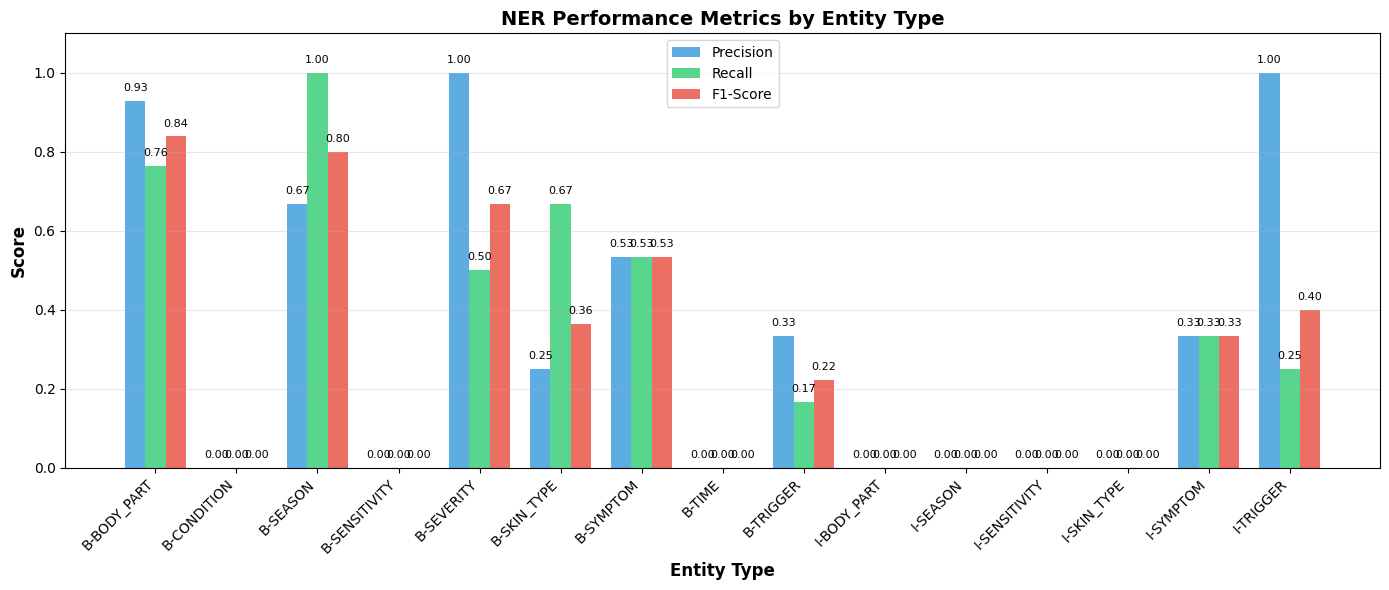

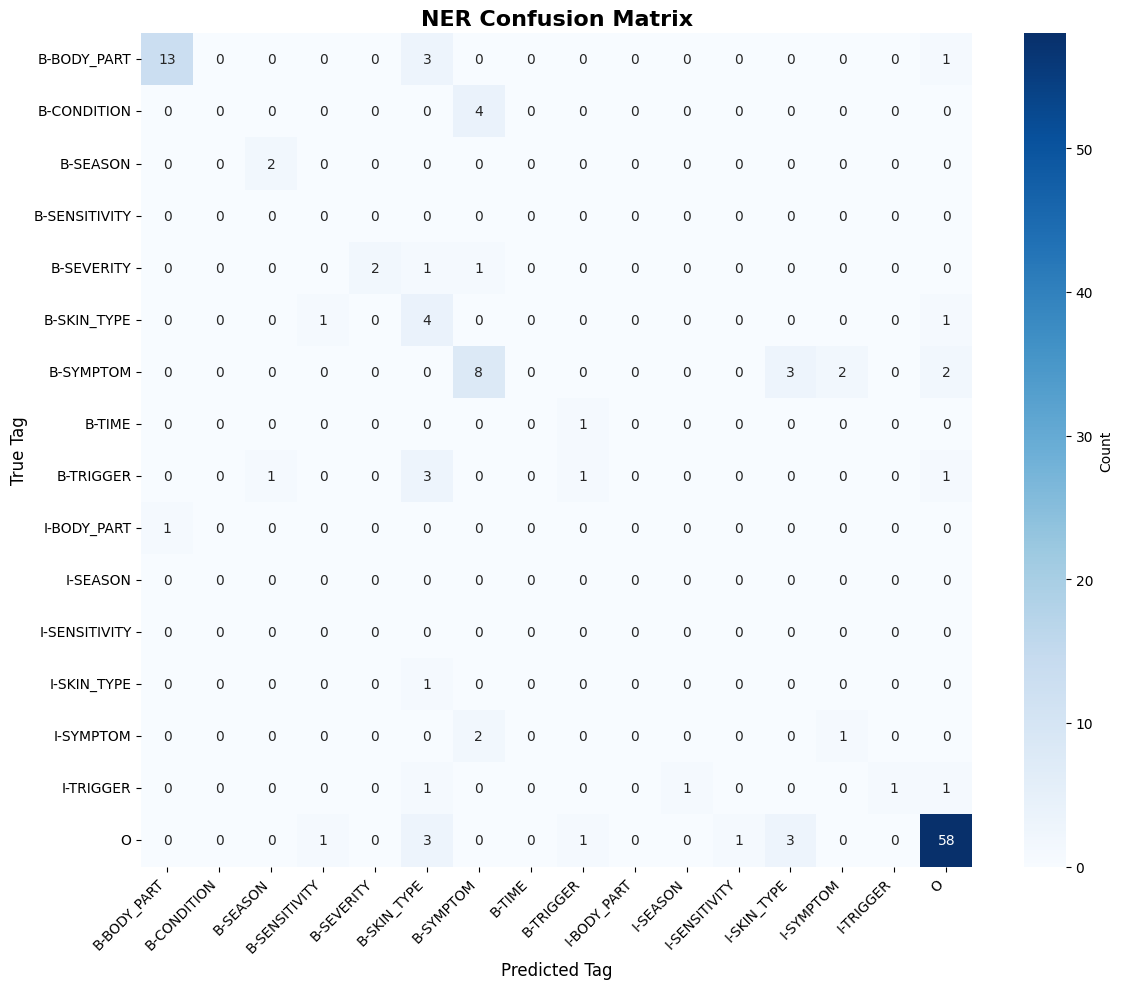


✓ Evaluation complete!


In [206]:
# ============================================
# NER MODEL EVALUATION - ROBUST FIX
# Handles Unknown Tokens & CRF Masking Errors
# ============================================
import numpy as np
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
# ============================================
# STEP 1: IDENTIFY YOUR VARIABLE NAMES
# ============================================
MODEL_NAME = model  # Your model variable
TEST_DATA = test_sentences  # Your test sentences
WORD2IDX = word2idx  # Your word2idx mapping
TAG2IDX = tag2idx  # Your tag2idx mapping
IDX2TAG = idx2tag  # Your idx2tag mapping
DEVICE_NAME = 'cpu'  # Change to 'cuda' if using GPU
def get_safe_unk_index(word2idx):
    """
    Finds a safe index for unknown words.
    Prioritizes explicit UNK tokens, otherwise uses index 1 (assuming 0 is padding).
    """
    # Try common unknown token variations
    for token in ['<UNK>', 'UNK', '[UNK]', 'unk', '<unk>']:
        if token in word2idx:
            return word2idx[token]
    
    # If no UNK token found, return 1 (assuming 0 is padding)
    # If vocab is tiny, ensure we don't go out of bounds
    if len(word2idx) > 1:
        return 1
    return 0  # Fallback (might still crash if 0 is padding, but rare)
def evaluate_ner_model(model, test_sentences, test_tags, word2idx, idx2tag, device='cpu'):
    """
    Comprehensive NER evaluation with token-level metrics
    """
    model.eval()
    
    all_true_tags = []
    all_pred_tags = []
    
    # Get safe unknown token index
    unk_idx = get_safe_unk_index(word2idx)
    print(f"Using index {unk_idx} for unknown words.")
    
    print(f"Evaluating on {len(test_sentences)} test sentences...")
    
    with torch.no_grad():
        for i, (sentence, true_tags) in enumerate(zip(test_sentences, test_tags)):
            if i % 100 == 0:
                print(f"  Processed {i}/{len(test_sentences)} sentences...")
            
            # Convert sentence to indices with SAFE fallback
            word_indices = []
            for word in sentence:
                if word in word2idx:
                    word_indices.append(word2idx[word])
                else:
                    word_indices.append(unk_idx)
            
            # Ensure we don't pass empty sentences
            if not word_indices:
                continue
                
            # Create input tensor
            input_tensor = torch.tensor([word_indices], dtype=torch.long).to(device)
            
            # Get model predictions
            try:
                # The model.forward() returns a LIST of tag indices directly
                pred_tag_indices_list = model(input_tensor)
                pred_tag_indices = pred_tag_indices_list[0]
                
                # Convert indices to tags
                pred_tags = [idx2tag[idx] for idx in pred_tag_indices]
                
                # Align predictions with true tags
                min_len = min(len(true_tags), len(pred_tags))
                all_true_tags.extend(true_tags[:min_len])
                all_pred_tags.extend(pred_tags[:min_len])
                
            except ValueError as e:
                print(f"⚠️ Skipped sentence {i} due to error: {e}")
                continue
            except Exception as e:
                print(f"⚠️ Unexpected error on sentence {i}: {e}")
                continue
    
    print(f"✓ Evaluation complete! Total tokens: {len(all_true_tags)}")
    return all_true_tags, all_pred_tags
def calculate_entity_metrics(true_tags, pred_tags):
    """
    Calculate precision, recall, F1 per entity type
    """
    # Get unique tags (excluding 'O')
    unique_tags = sorted(set(true_tags + pred_tags))
    entity_tags = [tag for tag in unique_tags if tag != 'O']
    
    metrics = {}
    
    for entity_type in entity_tags:
        # True Positives: correctly predicted entity
        tp = sum(1 for true, pred in zip(true_tags, pred_tags) 
                if true == entity_type and pred == entity_type)
        
        # False Positives: predicted entity but wrong
        fp = sum(1 for true, pred in zip(true_tags, pred_tags) 
                if true != entity_type and pred == entity_type)
        
        # False Negatives: missed entity
        fn = sum(1 for true, pred in zip(true_tags, pred_tags) 
                if true == entity_type and pred != entity_type)
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics[entity_type] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': sum(1 for tag in true_tags if tag == entity_type)
        }
    
    return metrics
def print_evaluation_report(metrics, true_tags, pred_tags):
    """
    Print comprehensive evaluation report
    """
    print("\n" + "=" * 80)
    print("NER MODEL EVALUATION REPORT")
    print("=" * 80)
    print()
    
    # Overall accuracy
    if len(true_tags) > 0:
        accuracy = sum(1 for t, p in zip(true_tags, pred_tags) if t == p) / len(true_tags)
        print(f"Overall Token Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"Total Tokens Evaluated: {len(true_tags):,}")
    else:
        print("No tokens evaluated.")
    print()
    
    # Per-entity metrics
    print("-" * 80)
    print(f"{'Entity Type':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-" * 80)
    
    for entity_type, scores in sorted(metrics.items()):
        print(f"{entity_type:<20} {scores['precision']:<12.4f} {scores['recall']:<12.4f} "
              f"{scores['f1']:<12.4f} {scores['support']:<10}")
    
    print("-" * 80)
    
    # Macro averages
    if metrics:
        macro_precision = np.mean([m['precision'] for m in metrics.values()])
        macro_recall = np.mean([m['recall'] for m in metrics.values()])
        macro_f1 = np.mean([m['f1'] for m in metrics.values()])
        
        print(f"{'Macro Average':<20} {macro_precision:<12.4f} {macro_recall:<12.4f} {macro_f1:<12.4f}")
        
        # Weighted averages
        total_support = sum(m['support'] for m in metrics.values())
        if total_support > 0:
            weighted_precision = sum(m['precision'] * m['support'] for m in metrics.values()) / total_support
            weighted_recall = sum(m['recall'] * m['support'] for m in metrics.values()) / total_support
            weighted_f1 = sum(m['f1'] * m['support'] for m in metrics.values()) / total_support
            
            print(f"{'Weighted Average':<20} {weighted_precision:<12.4f} {weighted_recall:<12.4f} {weighted_f1:<12.4f}")
    
    print("=" * 80)
def plot_confusion_matrix(true_tags, pred_tags):
    """
    Plot confusion matrix for NER predictions
    """
    if not true_tags:
        return
    # Get unique tags
    tag_names = sorted(set(true_tags + pred_tags))
    
    # Create confusion matrix
    cm = confusion_matrix(true_tags, pred_tags, labels=tag_names)
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=tag_names, yticklabels=tag_names,
                cbar_kws={'label': 'Count'})
    plt.title('NER Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Tag', fontsize=12)
    plt.ylabel('True Tag', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
def plot_entity_metrics(metrics):
    """
    Plot precision, recall, F1 per entity type
    """
    if not metrics:
        print("No entity metrics to plot")
        return
    
    entity_types = list(metrics.keys())
    precisions = [metrics[e]['precision'] for e in entity_types]
    recalls = [metrics[e]['recall'] for e in entity_types]
    f1_scores = [metrics[e]['f1'] for e in entity_types]
    
    x = np.arange(len(entity_types))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.bar(x - width, precisions, width, label='Precision', color='#3498db', alpha=0.8)
    ax.bar(x, recalls, width, label='Recall', color='#2ecc71', alpha=0.8)
    ax.bar(x + width, f1_scores, width, label='F1-Score', color='#e74c3c', alpha=0.8)
    
    ax.set_xlabel('Entity Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('NER Performance Metrics by Entity Type', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(entity_types, rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1.1)
    
    # Add value labels on bars
    for i, (p, r, f) in enumerate(zip(precisions, recalls, f1_scores)):
        ax.text(i - width, p + 0.02, f'{p:.2f}', ha='center', va='bottom', fontsize=8)
        ax.text(i, r + 0.02, f'{r:.2f}', ha='center', va='bottom', fontsize=8)
        ax.text(i + width, f + 0.02, f'{f:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
# ============================================
# MAIN EVALUATION EXECUTION
# ============================================
print("Starting NER Model Evaluation...")
print()
# Check if test data exists
if 'test_sentences' not in dir() or 'test_tags' not in dir():
    print("⚠️ ERROR: test_sentences and test_tags not found!")
    print("\nPlease run the synthetic data creation cell first!")
else:
    # Evaluate model on test set
    true_tags, pred_tags = evaluate_ner_model(
        model=MODEL_NAME,
        test_sentences=test_sentences,
        test_tags=test_tags,
        word2idx=WORD2IDX,
        idx2tag=IDX2TAG,
        device=DEVICE_NAME
    )
    
    # Calculate metrics per entity type
    entity_metrics = calculate_entity_metrics(true_tags, pred_tags)
    
    # Print comprehensive report
    print_evaluation_report(entity_metrics, true_tags, pred_tags)
    
    # Visualize metrics
    plot_entity_metrics(entity_metrics)
    
    # Plot confusion matrix
    plot_confusion_matrix(true_tags, pred_tags)
    
    print("\n✓ Evaluation complete!")

In [207]:
import torch

# Define device (use 'cuda' if you have a GPU, otherwise 'cpu')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Test a specific sentence to see what the model thinks
test_sent = "I have severe acne on my face".split()

# Create input tensor
input_tensor = torch.tensor([[word2idx.get(w, word2idx.get('<UNK>', 1)) for w in test_sent]], dtype=torch.long).to(DEVICE)

# Get predictions
preds = model(input_tensor)[0]
pred_tags = [idx2tag[i] for i in preds]

# Print result
print(list(zip(test_sent, pred_tags)))

[('I', 'O'), ('have', 'O'), ('severe', 'B-SEVERITY'), ('acne', 'B-SYMPTOM'), ('on', 'O'), ('my', 'O'), ('face', 'B-BODY_PART')]


In [208]:
# SAVE MODEL, VOCABULARY, AND CORPUS FOR FRONTEND
import json
import torch

print("Saving model, vocabulary, and corpus...")

# 1. Save Model State Dict
torch.save(model.state_dict(), 'model.pth')
print("✓ Model saved to model.pth")

# 2. Save Vocabulary Mappings
vocab_data = {
    'word2idx': word2idx,
    'tag2idx': tag2idx,
    'idx2tag': idx2tag,
    'idx2word': idx2word
}

with open('vocab.json', 'w', encoding='utf-8') as f:
    json.dump(vocab_data, f, indent=2)
print("✓ Vocabulary saved to vocab.json")

# 3. Save Enhanced Corpus
# Assuming 'enhanced_corpus' is defined in the notebook
with open('corpus.json', 'w', encoding='utf-8') as f:
    json.dump(enhanced_corpus, f, indent=2)
print("✓ Corpus saved to corpus.json")

# 4. Save Corpus Embeddings (Optional but good for speed)
# Assuming 'corpus_embeddings' exists
torch.save(corpus_embeddings, 'corpus_embeddings.pt')
print("✓ Corpus embeddings saved to corpus_embeddings.pt")

print("\nREADY FOR FRONTEND!")

Saving model, vocabulary, and corpus...
✓ Model saved to model.pth
✓ Vocabulary saved to vocab.json
✓ Corpus saved to corpus.json


NameError: name 'corpus_embeddings' is not defined